### Необходимык библиотеки

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(20, 12)})

In [3]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}
</style>

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/Colab Notebooks/Диплом
%ls

### Подготавливаем данные

In [119]:
comments_raw_data = pd.read_excel('комментарии_банки.xlsx')

comments_raw_data['datePublished'] = pd.to_datetime(comments_raw_data['datePublished'])
comments_raw_data = comments_raw_data.drop(columns=['Unnamed: 0'])

In [120]:
comments_raw_data

bank            author       datePublished  \
0         vwbank         Bayazitof 2022-03-25 20:01:53   
1         vwbank  user-90277016293 2022-01-26 12:23:32   
2         vwbank           UserBox 2022-01-21 01:46:04   
3         vwbank     Sony Ericsson 2021-11-18 18:25:53   
4         vwbank          shulgaiv 2021-09-14 21:49:55   
...          ...               ...                 ...   
234654  alfabank             v.lan 2020-04-06 21:46:19   
234655  alfabank              Nut7 2020-04-06 19:36:25   
234656  alfabank       user3998572 2020-04-06 18:05:21   
234657  alfabank        Наталья202 2020-04-06 12:55:31   
234658  alfabank        BerezhnoyA 2020-04-06 09:21:28   

                                              description  \
0       Брал автокредит в этом году, сам банк был райф...   
1       Возникла проблема по кредитному договору. Трет...   
2       Сказать, что возмущен - не сказать ничего. Вир...   
3       16.09.2021 оформил кредит. Номер договора 03**...   
4       26.08.2021г. с ООО «Фольксваген Банк РУС» закл...   
...                                                   ...   
234654  22 января 2020 года решил заказать себе Альфа ...   
234655  Добрый день!В 2008 году мы с супругом взяли ип...   
234656  Спустя 2 месяца  пользования кредитной картой ...   
234657  Здравствуйте. Оставила заявку на сайте Альфа-б...   
234658  03 апреля 2020 по номеру счёта вносил денежные...   

                                                     name  rating  
0                        Брали автокредит, смутила оценка     4.0  
1                               Отсутствие связи с банком     1.0  
2                  Передают некорректную информацию в БКИ     1.0  
3                                     Досрочное погашение     1.0  
4                   Нарушение банком условий кредитования     1.0  
...                                                   ...     ...  
234654      Создание максимума сложностей на пустом месте     2.0  
234655                    Справка о ссудной задолженности     1.0  
234656       Подключение страховки через смс без согласия     1.0  
234657                                          Претензия     1.0  
234658  Деньги не поступили на счёт, вносил через банк...     1.0  

[234659 rows x 6 columns]

### Cтатистики

Text(0.5, 1.0, 'Кол-во статей с отзывов c 2019 по 2023')

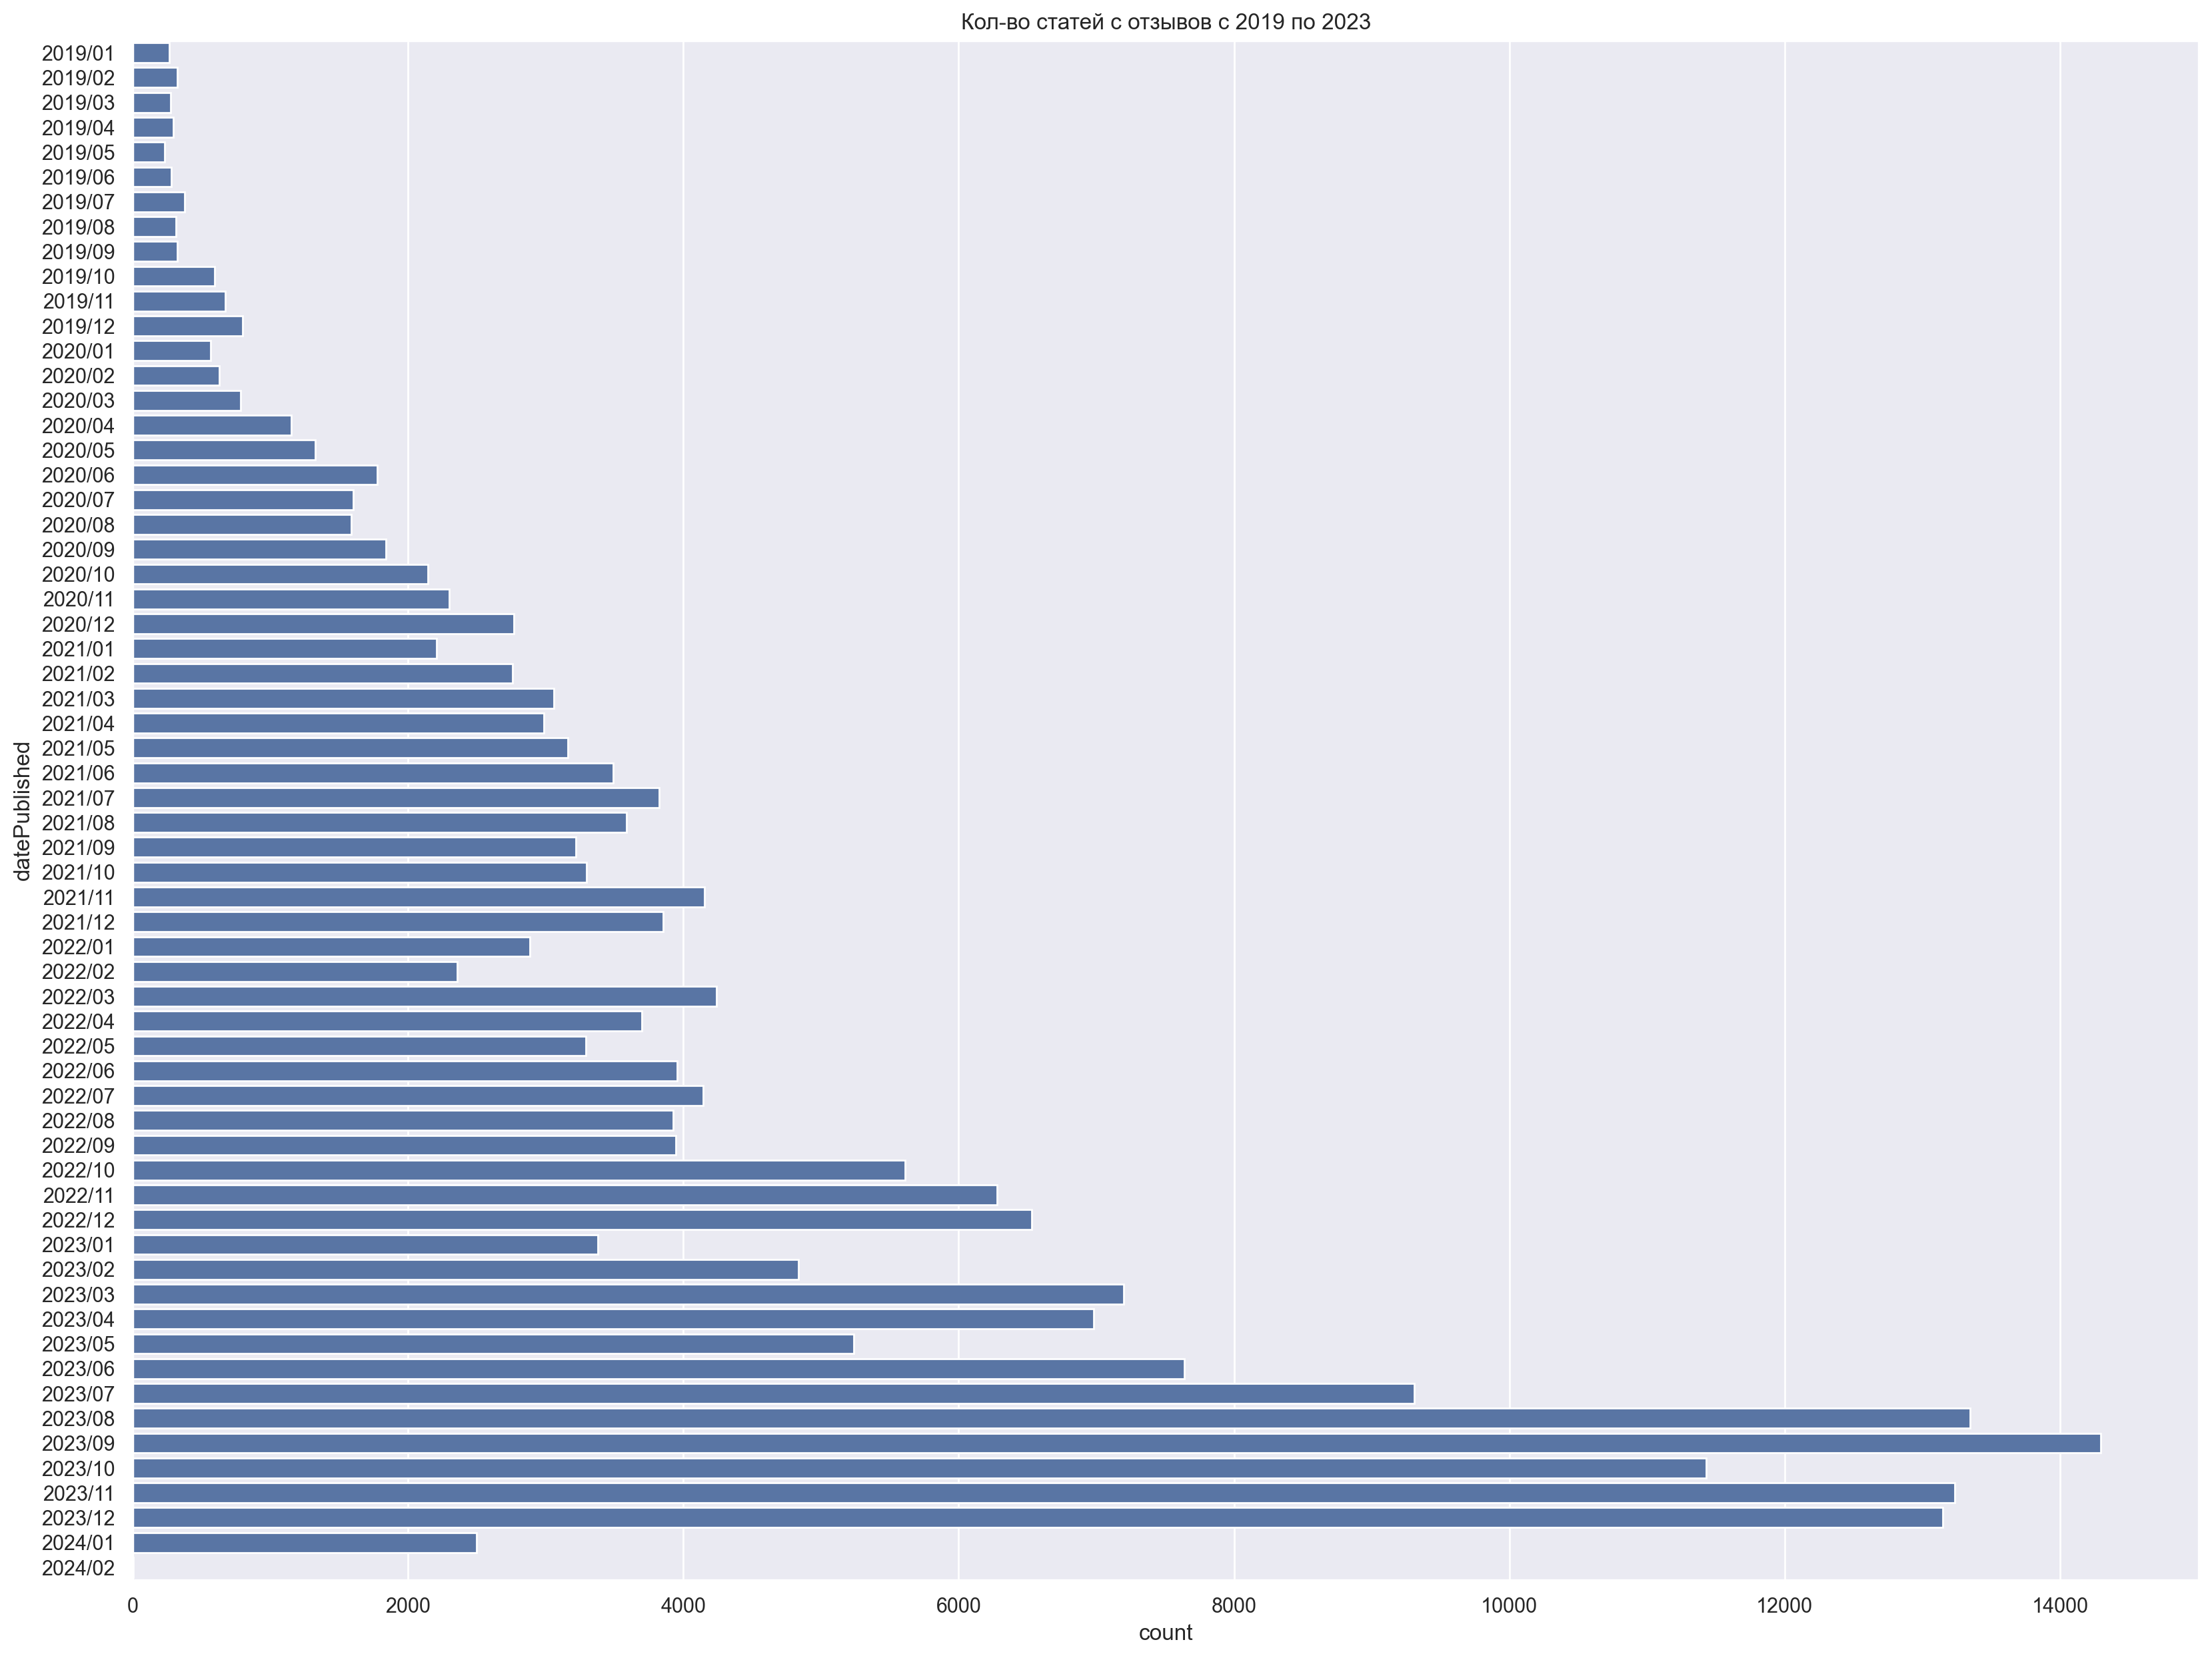

In [6]:
sns.set(rc={'figure.figsize':(20, 15)})
sns.countplot(comments_raw_data[comments_raw_data['datePublished'].dt.year >= 2019]['datePublished'].dt.strftime('%Y/%m').sort_values()).set_title(f'Кол-во статей с отзывов c {2019} по {2023}')

In [7]:
bank_counts = np.unique(comments_raw_data['bank'], return_counts=True)
popularity = sorted(list(zip(bank_counts[0], bank_counts[1])), key=lambda x:x[1], reverse=True)

names = [x[0] for x in popularity]
counts = [x[1] for x in popularity]

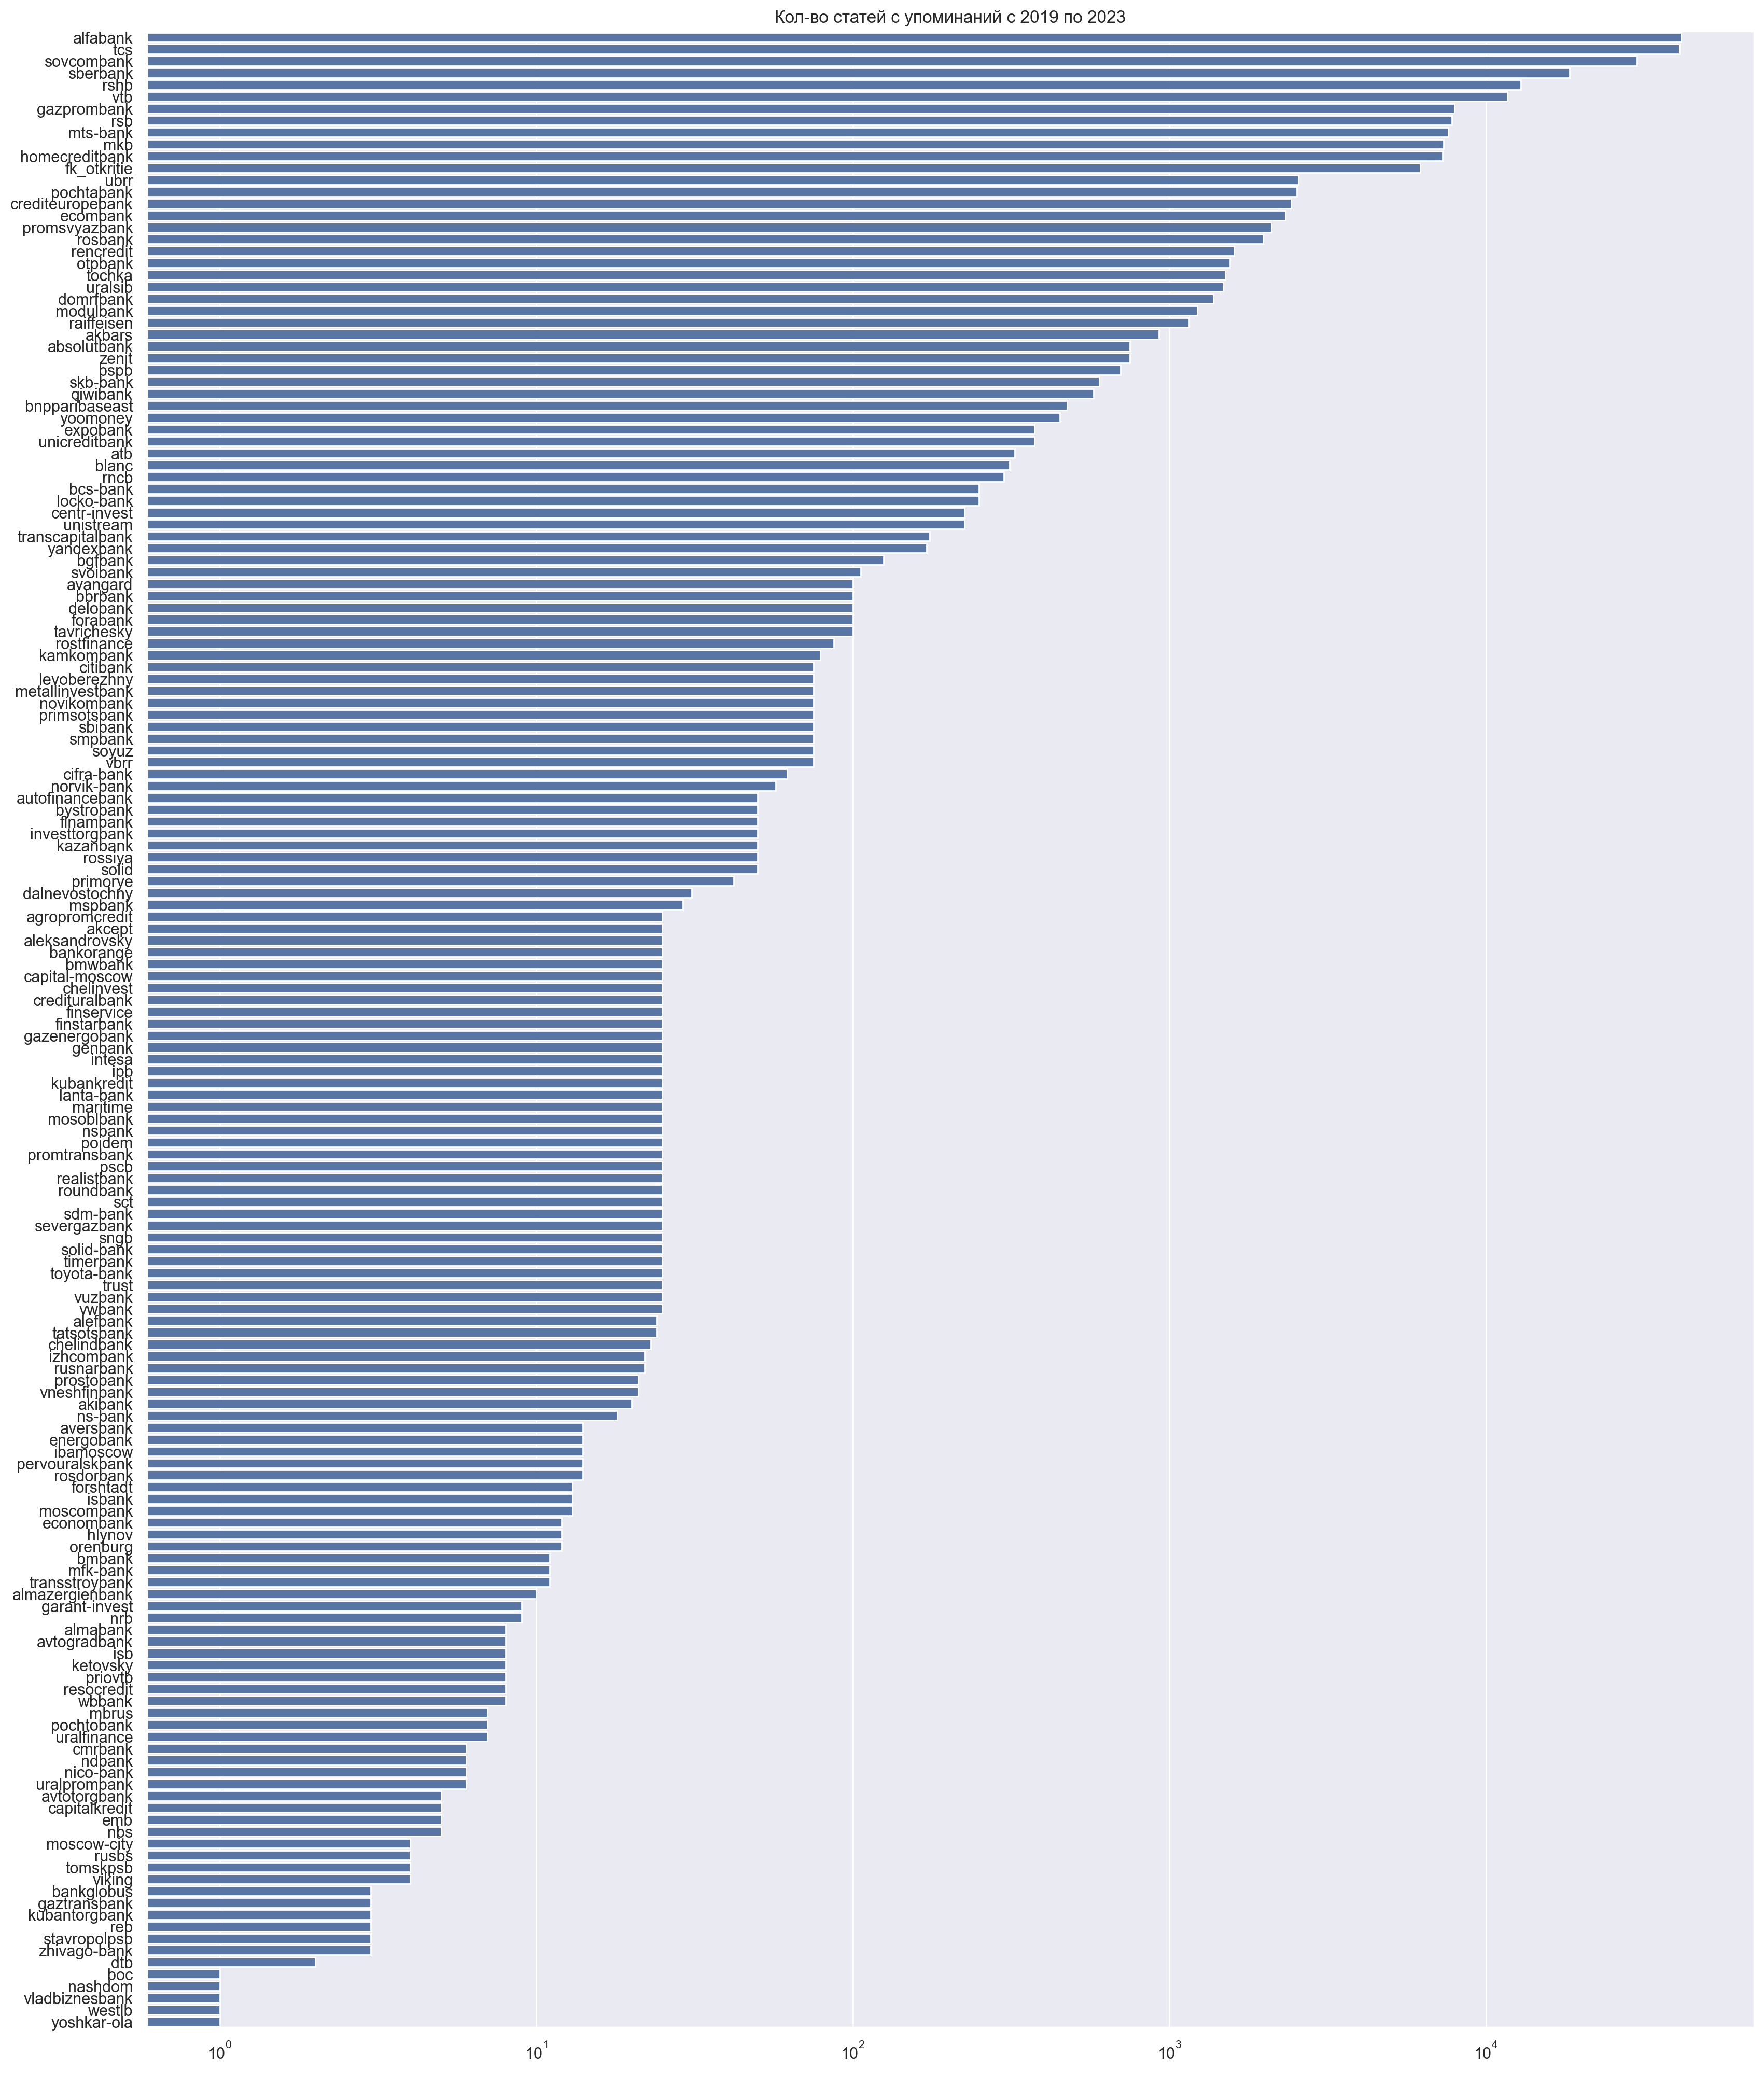

In [8]:
sns.set(rc={'figure.figsize':(20, 25)})

sns.barplot(x=counts, y=names).set_title(f'Кол-во статей с упоминаний c {2019} по {2023}')
plt.xscale('log')

In [20]:
from wordcloud import WordCloud

def draw_cloud(data):
    wc = WordCloud(background_color='white', max_words=1000,
                  width=1000, height=500, colormap='ocean')
    texts = data.astype(str)
    joint_text = ' '.join(list(texts))
    wc.generate(joint_text)
    return wc.to_image()

### Обработка текстов

In [5]:
data = comments_raw_data.dropna()[['description', 'bank', 'datePublished']]

In [6]:
data['year'] = data['datePublished'].dt.year

In [7]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("russian")
mystem = Mystem()
russian_stopwords = stopwords.words("russian")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilgarmamedov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
extended_punctuation = punctuation+'«'+'»'+'“'+'”'
digits = '0123456789'
web_tokens = ['quot', 'gt', 'lt', 'br', 'p', 'li', '&lt;/p&gt;']

def preprocess_text(text, transform, stemmer=stemmer, mystem=mystem, russian_stopwords=russian_stopwords, punctuation=extended_punctuation, digits=digits, web_tokens=web_tokens):
    text = text.lower()

    for i in web_tokens:
      text = text.replace(i, '')

    for i in punctuation:
      text = text.replace(i, '')

    for i in digits:
      text = text.replace(i, '')

    if transform == 'stemming':
        tokens = mystem.lemmatize(text)

    if transform == 'lemmatizing':
        tokens = [stemmer.stem(word) for word in text.split()]

    if transform is None:
        tokens = [word for word in text.split()]

    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " "]

    text = " ".join(tokens).strip()
    return text

In [17]:
# pip install pandarallel

In [5]:
from tqdm import tqdm
tqdm.pandas()

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [17]:
data['paper_stemming_text'] = data['description'].parallel_apply(lambda x: preprocess_text(str(x), transform='stemming'))

In [10]:
data['paper_lemmatizing_text'] = data['description'].parallel_apply(lambda x: preprocess_text(str(x), transform='lemmatizing'))

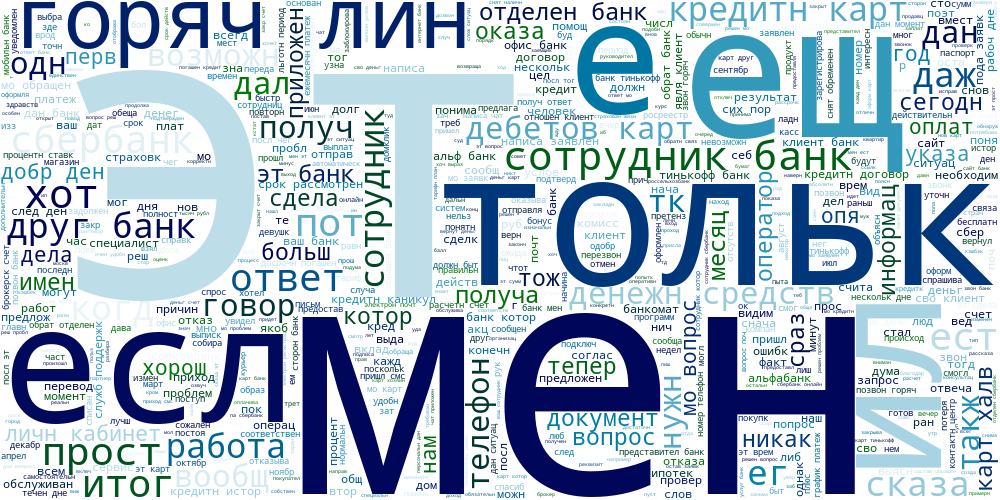

In [13]:
text = data[data['year'] == 2020]['paper_lemmatizing_text']
draw_cloud(text)

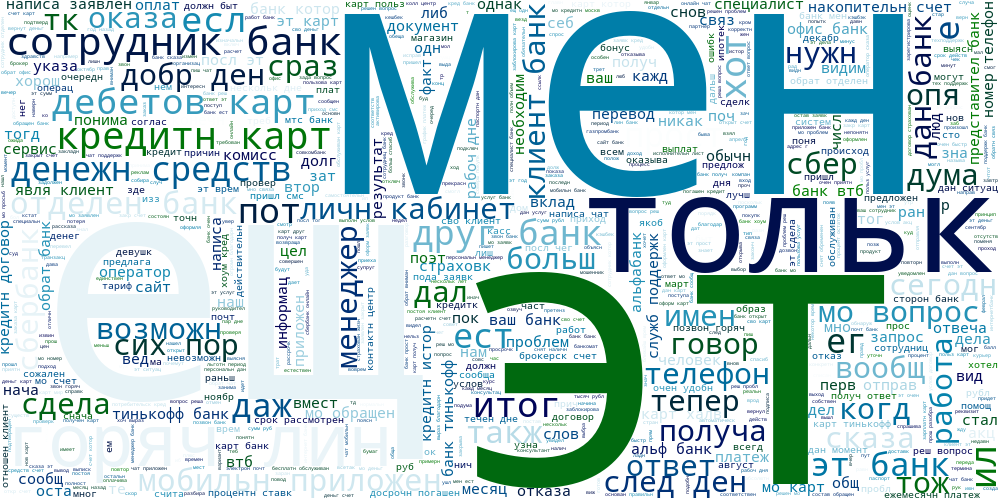

In [14]:
text = data[data['year'] == 2021]['paper_lemmatizing_text']
draw_cloud(text)

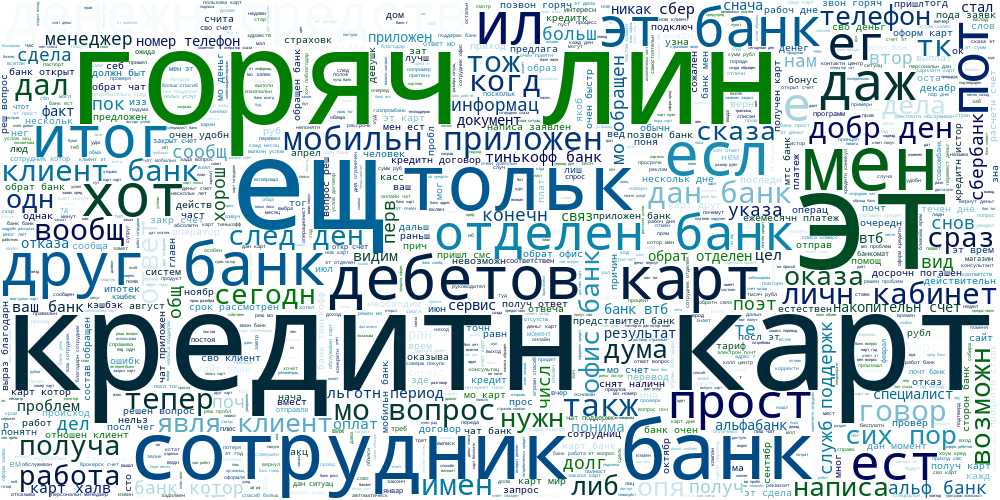

In [15]:
text = data[data['year'] == 2022]['paper_lemmatizing_text']
draw_cloud(text)

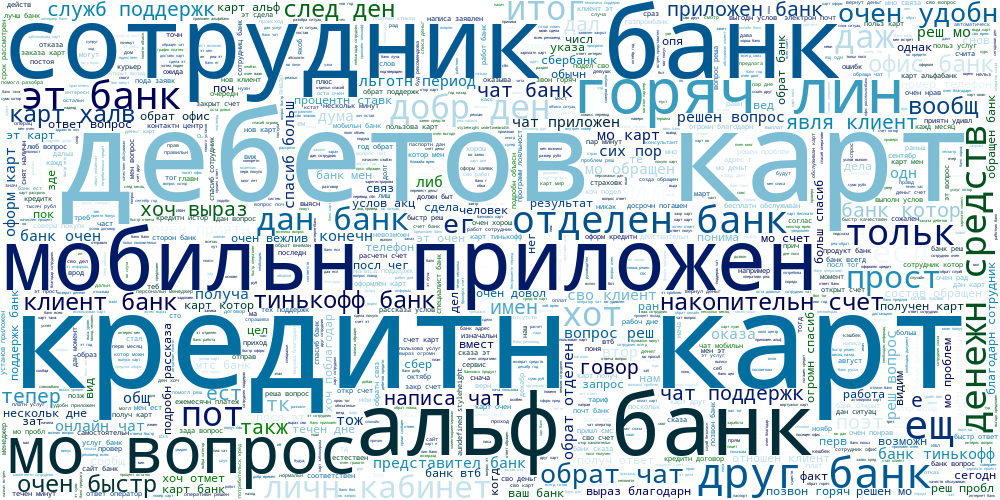

In [16]:
text = data[data['year'] == 2023]['paper_lemmatizing_text']
draw_cloud(text)

In [5]:
data[['bank', 'year', 'paper_stemming_text', 'paper_lemmatizing_text']].to_excel('preprocessed_nps.xlsx')

### Получение embeddings, необучаемые методы

In [4]:
data = pd.read_excel('preprocessed_nps.xlsx').drop(columns = ['Unnamed: 0'], axis=1)

In [5]:
mapper = pd.read_excel('mapper.xlsx')
mapper = mapper.set_index('bank').T.to_dict('records')[0]

In [6]:
data['bank'] = data['bank'].map(mapper)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
tfidf_stem = TfidfVectorizer(min_df=3)
tfidf_stem.fit(data['paper_stemming_text'])

tfidf_lem = TfidfVectorizer(min_df=3)
tfidf_lem.fit(data['paper_lemmatizing_text'])

TfidfVectorizer(min_df=3)

In [9]:
def get_vectors(text_cols, vectorizer, averaging, data=data, name_cols='bank'):

    cols = ['bank']+[x for x in range(len(vectorizer.vocabulary_))]
    bank_vectors = pd.DataFrame(columns=cols)

    if averaging == 'micro':
      for bank in tqdm(np.unique(data[name_cols])):
          bank_text = data[data[name_cols] == bank][text_cols]
          sen = np.mean(vectorizer.transform(bank_text), axis=0)
          vec = pd.DataFrame(sen)
          vec.insert(0, "bank", [bank])
          bank_vectors = pd.concat([bank_vectors, vec], axis=0)
      return bank_vectors

    if averaging == 'macro':
      df_size = len(data[text_cols])
      for i in tqdm(range(0, (df_size // 1000) + 1)):
        start_idx = i
        end_idx = i+999
        part_text = data[text_cols].loc[start_idx:end_idx]
        part_vectors = pd.DataFrame(vectorizer.transform(part_text).toarray())
        bank_vectors = pd.concat([bank_vectors, part_vectors], axis=0)
      bank_vectors.insert(0, "bank", data[name_cols].reset_index(drop=True))
      return bank_vectors

In [10]:
micro_stem_tfidf = get_vectors('paper_stemming_text', tfidf_stem, 'micro')
micro_lem_tfidf = get_vectors('paper_lemmatizing_text', tfidf_lem, 'micro')

  0%|          | 0/166 [00:00<?, ?it/s]/var/folders/0v/mjh6qpnj1jvg0mmzcsb5mz5r0000gn/T/ipykernel_1179/3201413443.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bank_vectors = pd.concat([bank_vectors, vec], axis=0)
  0%|          | 0/166 [00:00<?, ?it/s]/var/folders/0v/mjh6qpnj1jvg0mmzcsb5mz5r0000gn/T/ipykernel_1179/3201413443.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bank_vectors = pd.concat([bank_vectors, vec], axis=0)
100%|██████████| 166/166 [00:10<00:00, 15.40it/s]


### Метрики

In [13]:
# !pip install bcubed

In [14]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
import bcubed

In [15]:
index_data = pd.read_excel('bank_index.xlsx')
index_data = index_data[index_data['banks'].isin(list(pd.unique(micro_stem_tfidf['bank'])))]

In [16]:
def split_scores(num_groups, df=index_data):
    df_sorted = df.sort_values(by='index')
    quantiles = pd.qcut(df_sorted['index'], q=num_groups, labels=False)
    df_sorted['group'] = quantiles
    df_sorted = df_sorted.reset_index(drop=True)
    data = df_sorted[['banks', 'group']].set_index('banks')
    data['group'] = data['group'].apply(lambda x: set([str(x)]))
    clusters = data.T.to_dict('records')[0]
    return clusters

In [17]:
def form_equal_dict(dict1, dict2):
    if len(dict1.keys()) >= len(dict2.keys()):
      bigger = dict1
      smaller = dict2
    else:
      smaller = dict1
      bigger = dict2

    bigger = {k: v for (k,v) in bigger.items() if k in smaller.keys()}
    return bigger, smaller

In [18]:
def calc_metrics(embeds, labels, y_true, y_pred):
    y_true, y_pred = form_equal_dict(y_true, y_pred)
    precision_bcubed = bcubed.precision(y_pred, y_true)
    recall_bcubed = bcubed.recall(y_pred, y_true)
    fscore_bcubed = bcubed.fscore(precision_bcubed, recall_bcubed)

    if len(embeds['bank']) > len(pd.unique(embeds['bank'])):
        paper_labels = pd.DataFrame({'bank':list(embeds['bank']), 'label':labels})
        labels = paper_labels.groupby('bank')['label'].agg(lambda x: x.mode()[0])
        
        embeds = embeds.groupby('bank').mean().reset_index()
        labels = list(embeds.merge(labels, on='bank', how='left')['label'])

    embeds = embeds.iloc[:,1:]
    return davies_bouldin_score(embeds, labels), calinski_harabasz_score(embeds, labels), silhouette_score(embeds, labels), fscore_bcubed

### Кластеризация

In [19]:
def clustering_bank(embed_data, method, averaging):
    banks = list(pd.unique(embed_data['bank']))
    if averaging == 'micro':
        method.fit(embed_data.iloc[:,1:])
        return dict(zip(list(embed_data['bank']), [set(list(str(x))) for x in method.labels_])), method.labels_

    if averaging == 'macro':
      method.fit(embed_data.iloc[:,1:])
      paper_cluster = pd.DataFrame({'bank':list(embed_data['bank'])})
      paper_cluster['labels'] = method.labels_
      banks_cluster = {}
      for i in banks:
          banks_cluster[i] = set(list(str(paper_cluster[paper_cluster['bank'] == i]['labels'].mode().iloc[0])))
      return banks_cluster, method.labels_

In [20]:
n_cluster = [2,3,4,5,6]
notes = pd.DataFrame(columns=['embed', 'clusterng', 'transform', 'n_cluster', 'averaging', 'davies_bouldin', 'calinski_harabasz_score', 'silhouette_score', 'f1_bcubed'])

#### Kmeans

In [13]:
from sklearn.cluster import KMeans
sns.set(rc={'figure.figsize':(10, 10)})

def plot_inertia(embeds):
    rg = range(1, 10)
    inertia = []
    for k in tqdm(rg):
        kmeans = KMeans(n_clusters=k, random_state=4, n_init='auto').fit(embeds.iloc[:,1:])
        inertia.append(np.sqrt(kmeans.inertia_))

    plt.plot(rg, inertia, marker='s')
    plt.xlabel('$k$')
    plt.ylabel('$J(C_k)$')
    plt.show()

def calc_methods_kmeans(embeds, emb_alg, transform, averaging, notes=notes, n_cluster=n_cluster):
    for n in tqdm(n_cluster):
        kmeans = KMeans(n_clusters=n, n_init='auto', random_state=42)
        bank_cluster, embed_labels = clustering_bank(embeds, kmeans, averaging)
        db, ch, ss, bc = calc_metrics(embeds, embed_labels, split_scores(n), bank_cluster)
        notes.loc[len(notes)+1] = [emb_alg, 'k-means', transform, n, averaging, db, ch, ss, bc]

100%|██████████| 9/9 [00:02<00:00,  3.11it/s]


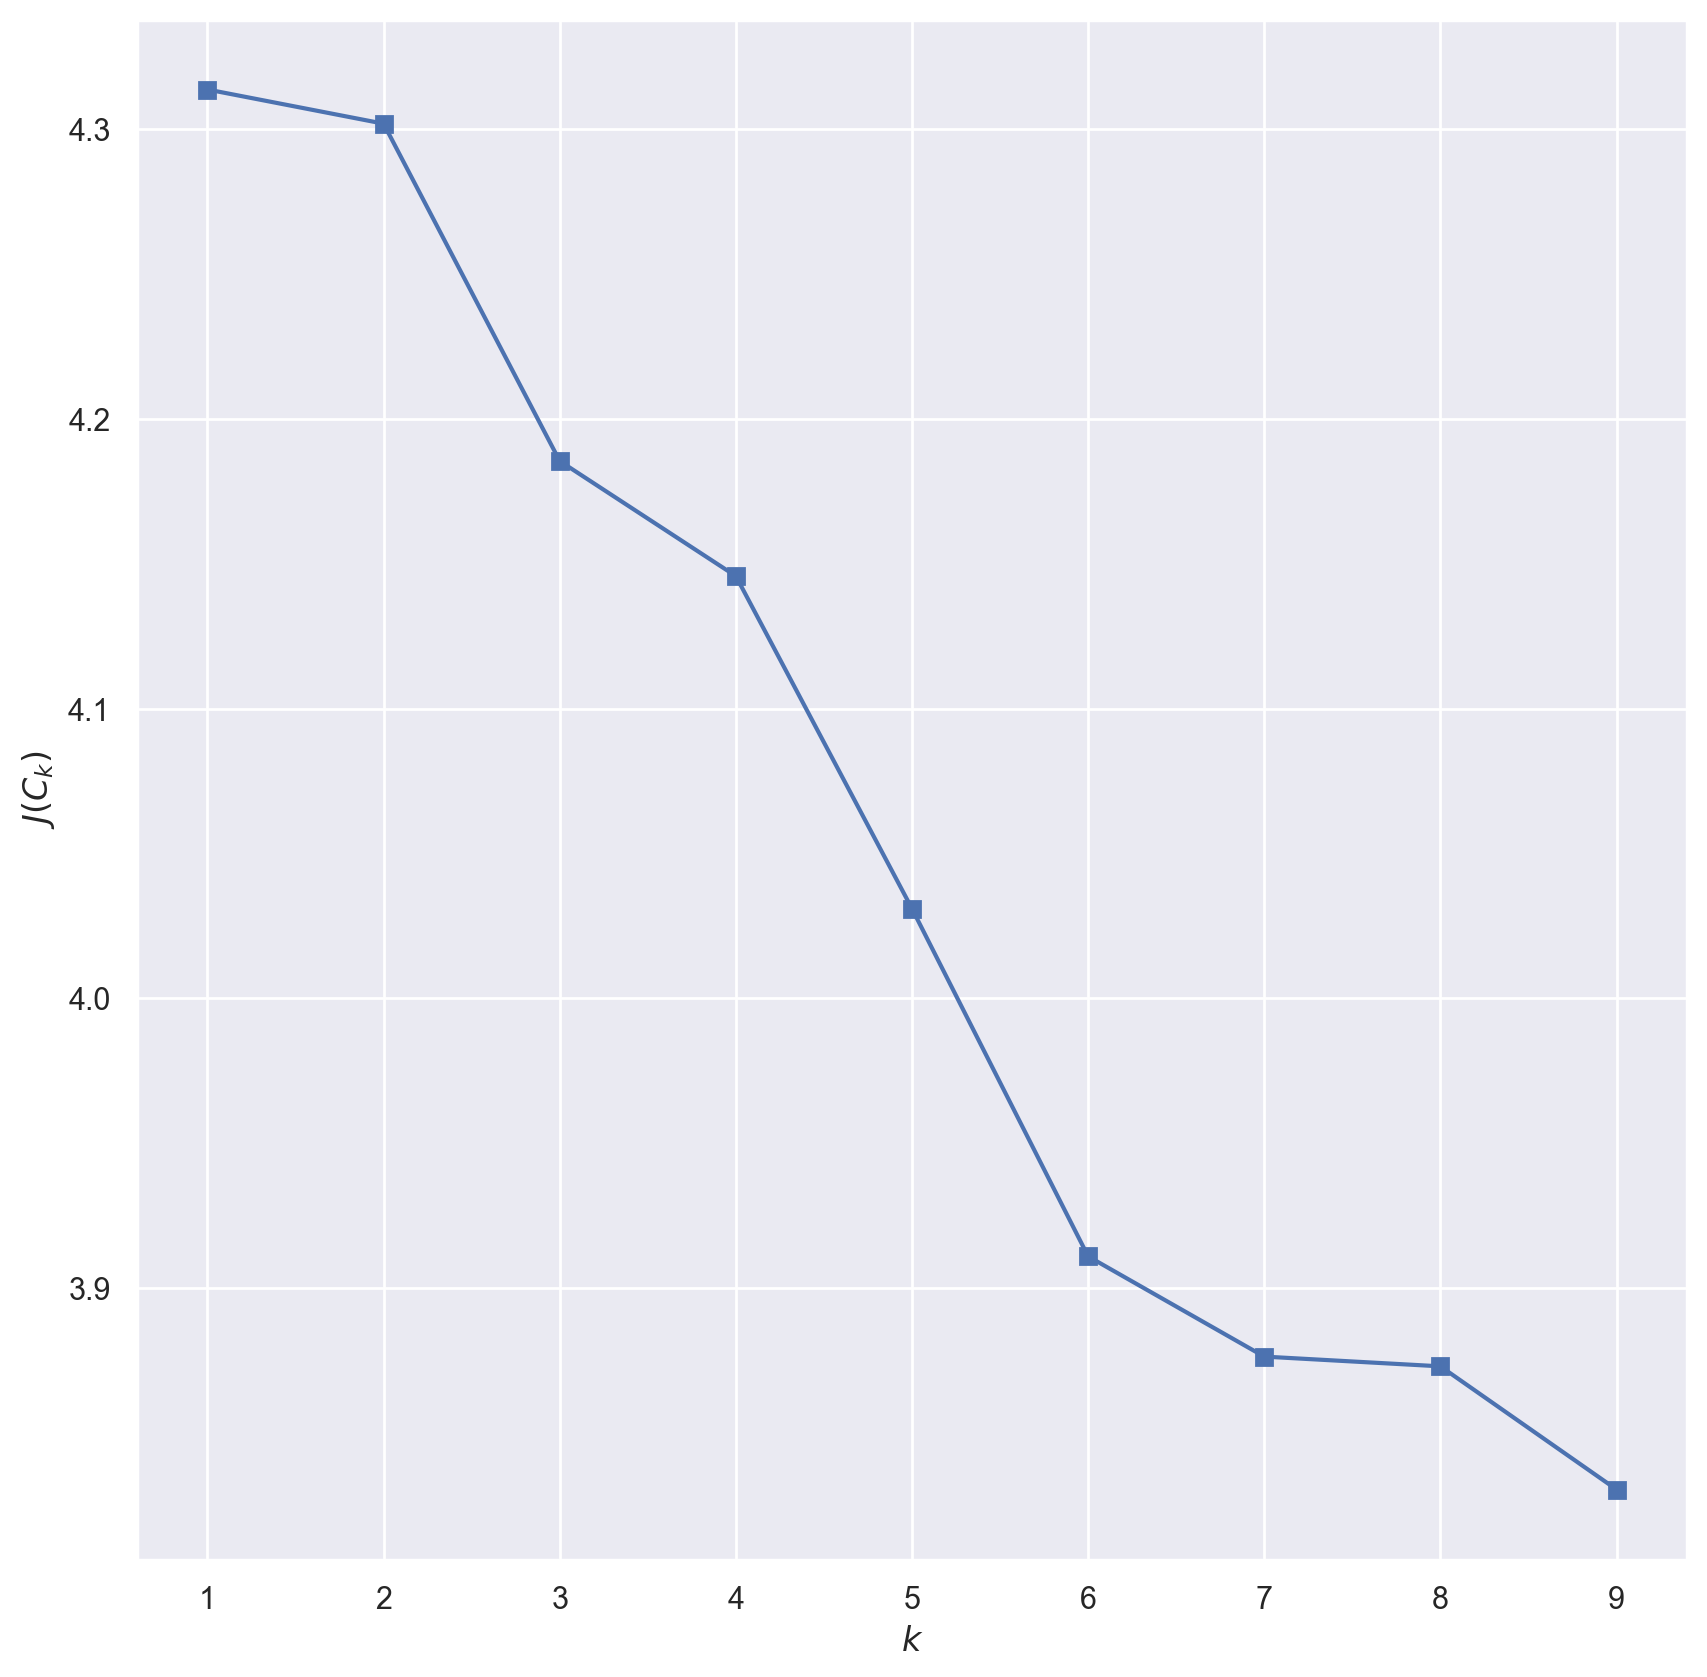

In [22]:
calc_methods_kmeans(micro_stem_tfidf, 'tf_idf', 'stem', 'micro')
plot_inertia(micro_stem_tfidf)

100%|██████████| 9/9 [00:02<00:00,  3.02it/s]


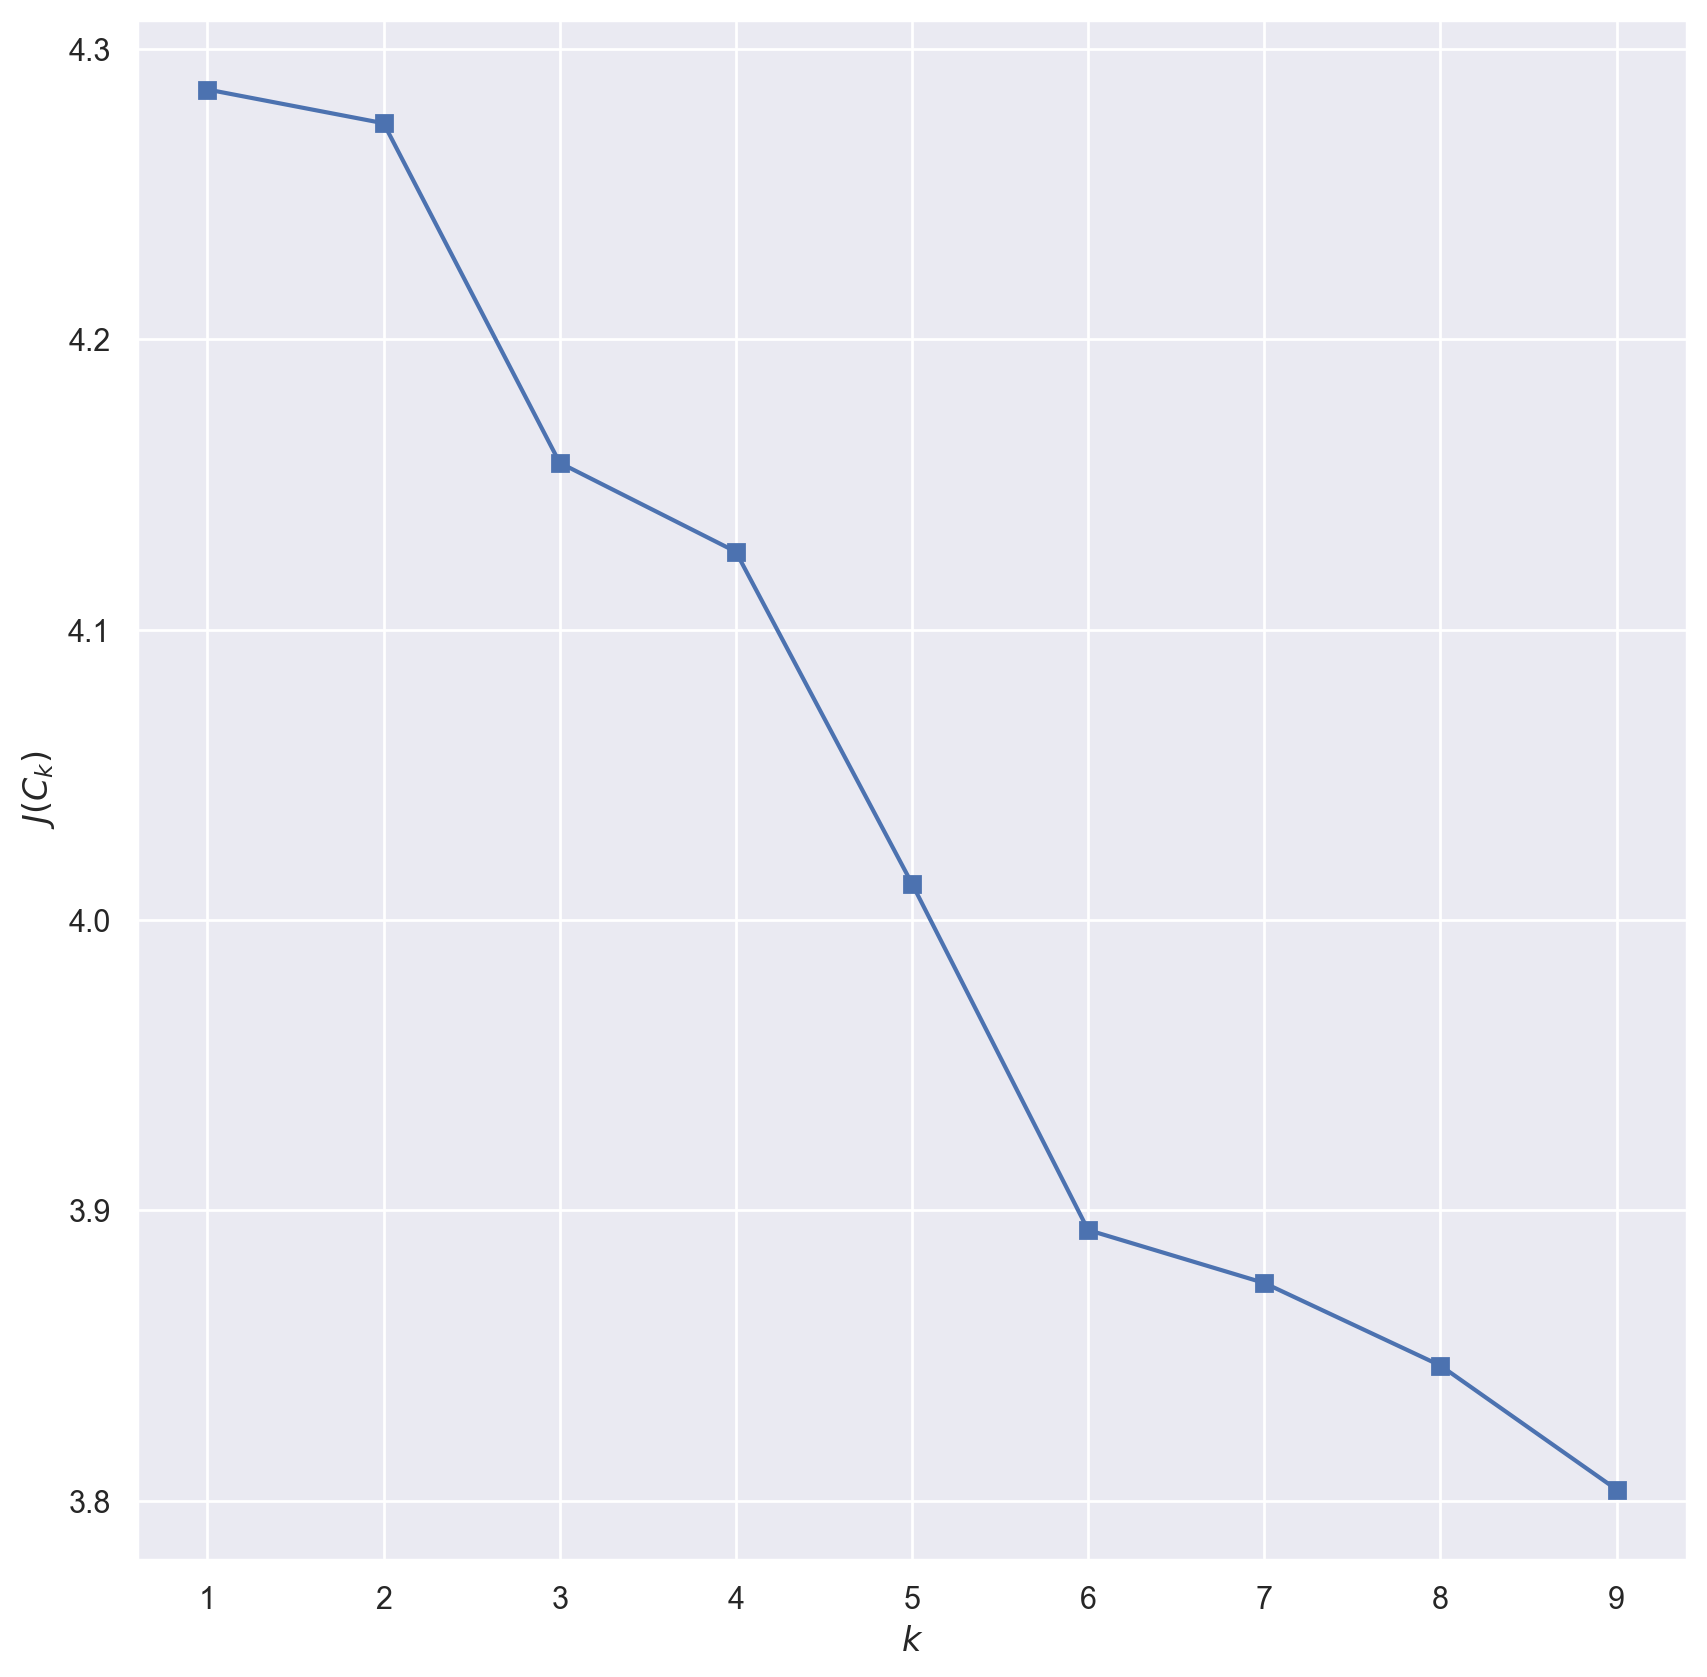

In [23]:
calc_methods_kmeans(micro_lem_tfidf, 'tf_idf', 'lem', 'micro')
plot_inertia(micro_lem_tfidf)

#### DBSCAN

In [24]:
from sklearn.cluster import DBSCAN
eps_list = [1.0 + 0.05 * x for x in range(17)]

def draw_anomaly_plot(embeds, eps = 0.1, eps_grow=0.01):
    # для начала считаем все наблюдения аномальными
    outlier_percentage = 1.

    num_clusters = []
    anomaly_percentage = []

    # берем маленький эпсилон и начинаем увеличивать
    eps_history = [eps]

    while outlier_percentage > 0.1:
        model = DBSCAN(eps=eps, min_samples=3).fit(embeds)

        labels = model.labels_
        num_clusters.append(len(np.unique(labels))-1)
        labels = np.array([1 if label == -1 else 0 for label in labels])

        # считаем текущий процент "шума"
        outlier_percentage = sum(labels==1) / len(labels)
        eps += eps_grow
        eps_history.append(eps)
        anomaly_percentage.append(outlier_percentage)


    iterations = eps_history[:-1]
    fig, ax1 = plt.subplots(figsize=(8,5))
    color = 'tab:red'
    ax1.set_xlabel('epsilon')
    ax1.set_ylabel('Number of clusters', color=color)
    ax1.plot(iterations, num_clusters, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # инициализация второй оси в соотвествии с размером первой

    color = 'tab:blue'
    ax2.set_ylabel('Anomaly %', color=color)
    ax2.plot(iterations, anomaly_percentage, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()

In [25]:
def calc_methods_dbscan(embeds, emb_alg, transform, averaging, notes=notes, eps_list=eps_list):
    for eps in tqdm(eps_list):
        dbscan = DBSCAN(eps=eps, min_samples=3)
        bank_cluster, embed_labels = clustering_bank(embeds, dbscan, averaging)
        try:
            n = np.unique(embed_labels).shape[0]
            db, ch, ss, bc = calc_metrics(embeds.iloc[:,1:], embed_labels, split_scores(n), bank_cluster)
            notes.loc[len(notes)+1] = [emb_alg, 'dbscan', transform, n, averaging, db, ch, ss, bc]
        except:
            continue

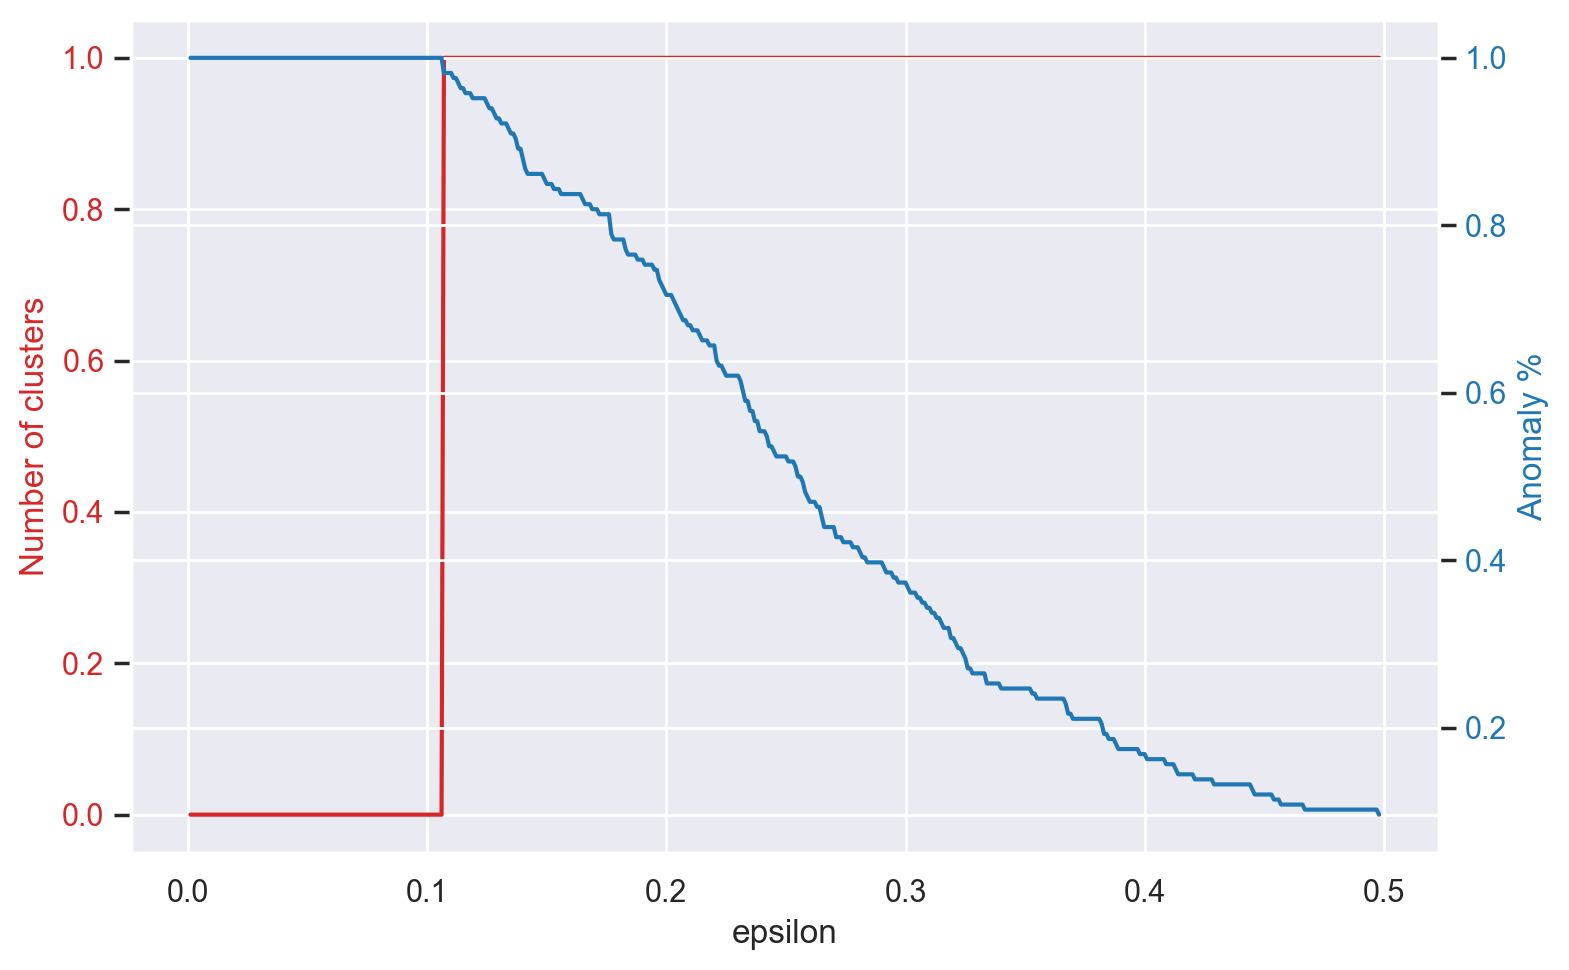

In [26]:
#eps_list = [0.4 + 0.001 * x for x in range(25)]
# calc_methods_dbscan(micro_lem_tfidf, 'tf_idf', 'lem', 'micro', eps_list=eps_list)
draw_anomaly_plot(micro_lem_tfidf.iloc[:,1:], eps=0.001, eps_grow=0.001)

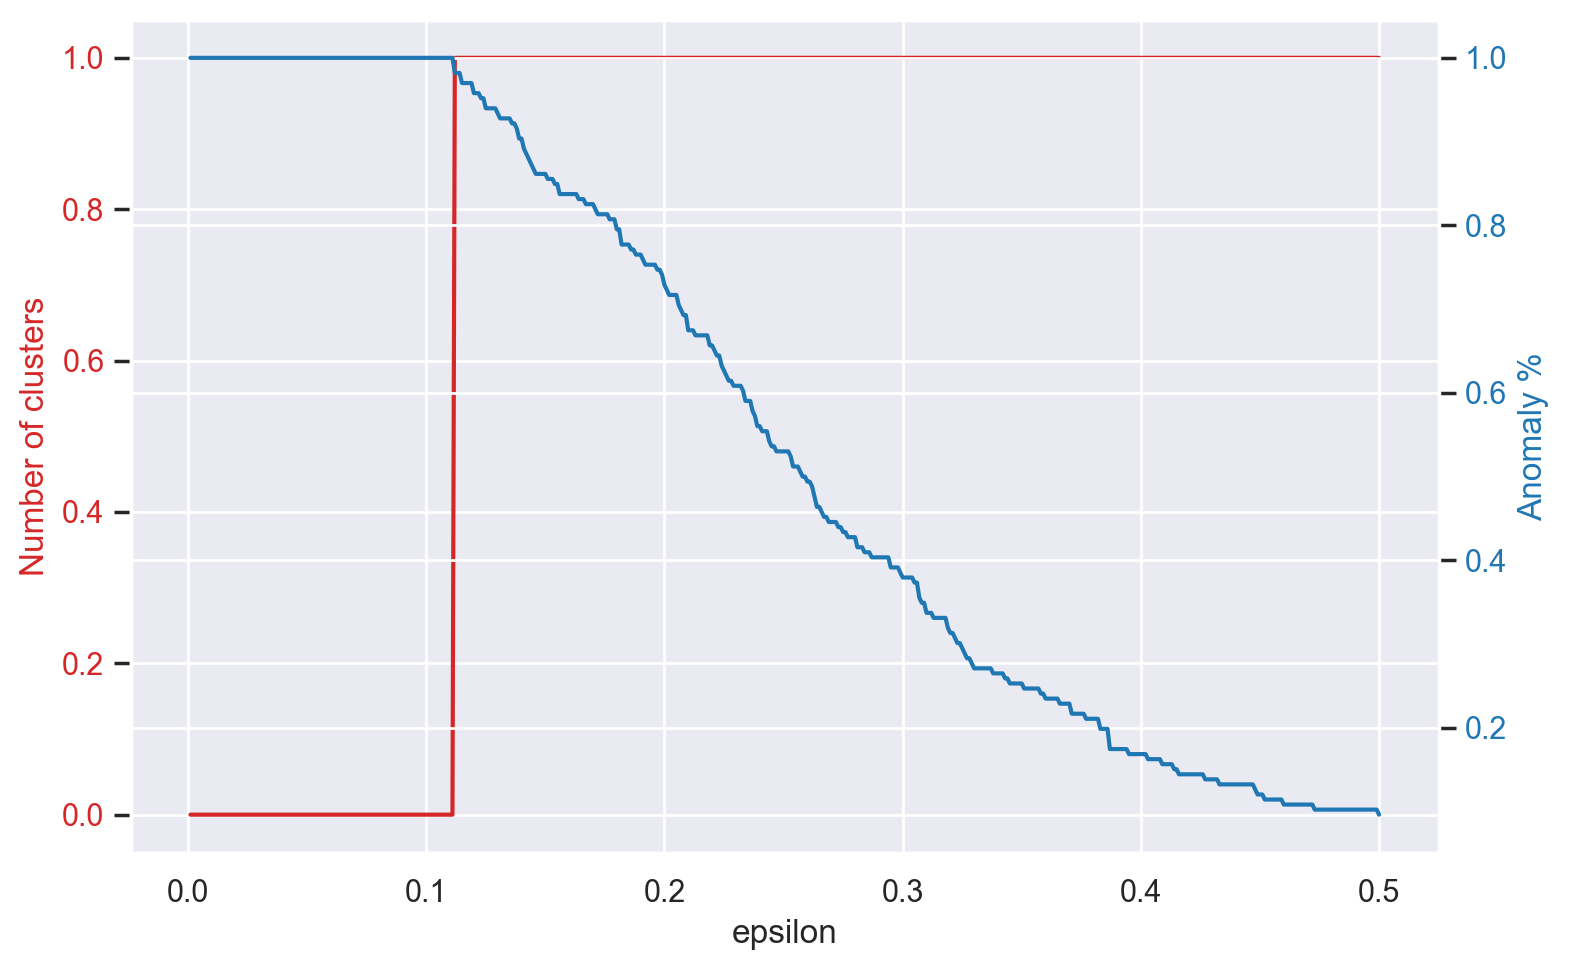

In [27]:
#eps_list = [0.4 + 0.001 * x for x in range(25)]
#calc_methods_dbscan(micro_stem_tfidf, 'tf_idf', 'stem', 'micro', eps_list=eps_list)
draw_anomaly_plot(micro_stem_tfidf.iloc[:,1:], eps=0.001, eps_grow=0.001)

#### Spectral

In [28]:
from sklearn.cluster import SpectralClustering
from scipy.sparse import csgraph

n_cluster = [2,3,4,5,6]

def draw_eigh(embeds):
    spectr = SpectralClustering(n_clusters=2, n_components=1, random_state=42)
    spectr.fit(embeds)
    L = csgraph.laplacian(spectr.affinity_matrix_)
    values, vectors = np.linalg.eigh(L)
    sns.lineplot(sorted(values[:10]))
    plt.plot()
    plt.ylabel('Eigenvalues')
    plt.xlabel('Numer of vectors')

def calc_methods_spectral(embeds, emb_alg, transform, averaging, notes=notes):
    for n in tqdm(n_cluster):
        spectr = SpectralClustering(n_clusters=n, n_components=n)
        bank_cluster, embed_labels = clustering_bank(embeds, spectr, averaging)
        db, ch, ss, bc = calc_metrics(embeds, embed_labels, split_scores(n), bank_cluster)
        notes.loc[len(notes)+1] = [emb_alg, 'spectr', transform, n, averaging, db, ch, ss, bc]

100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


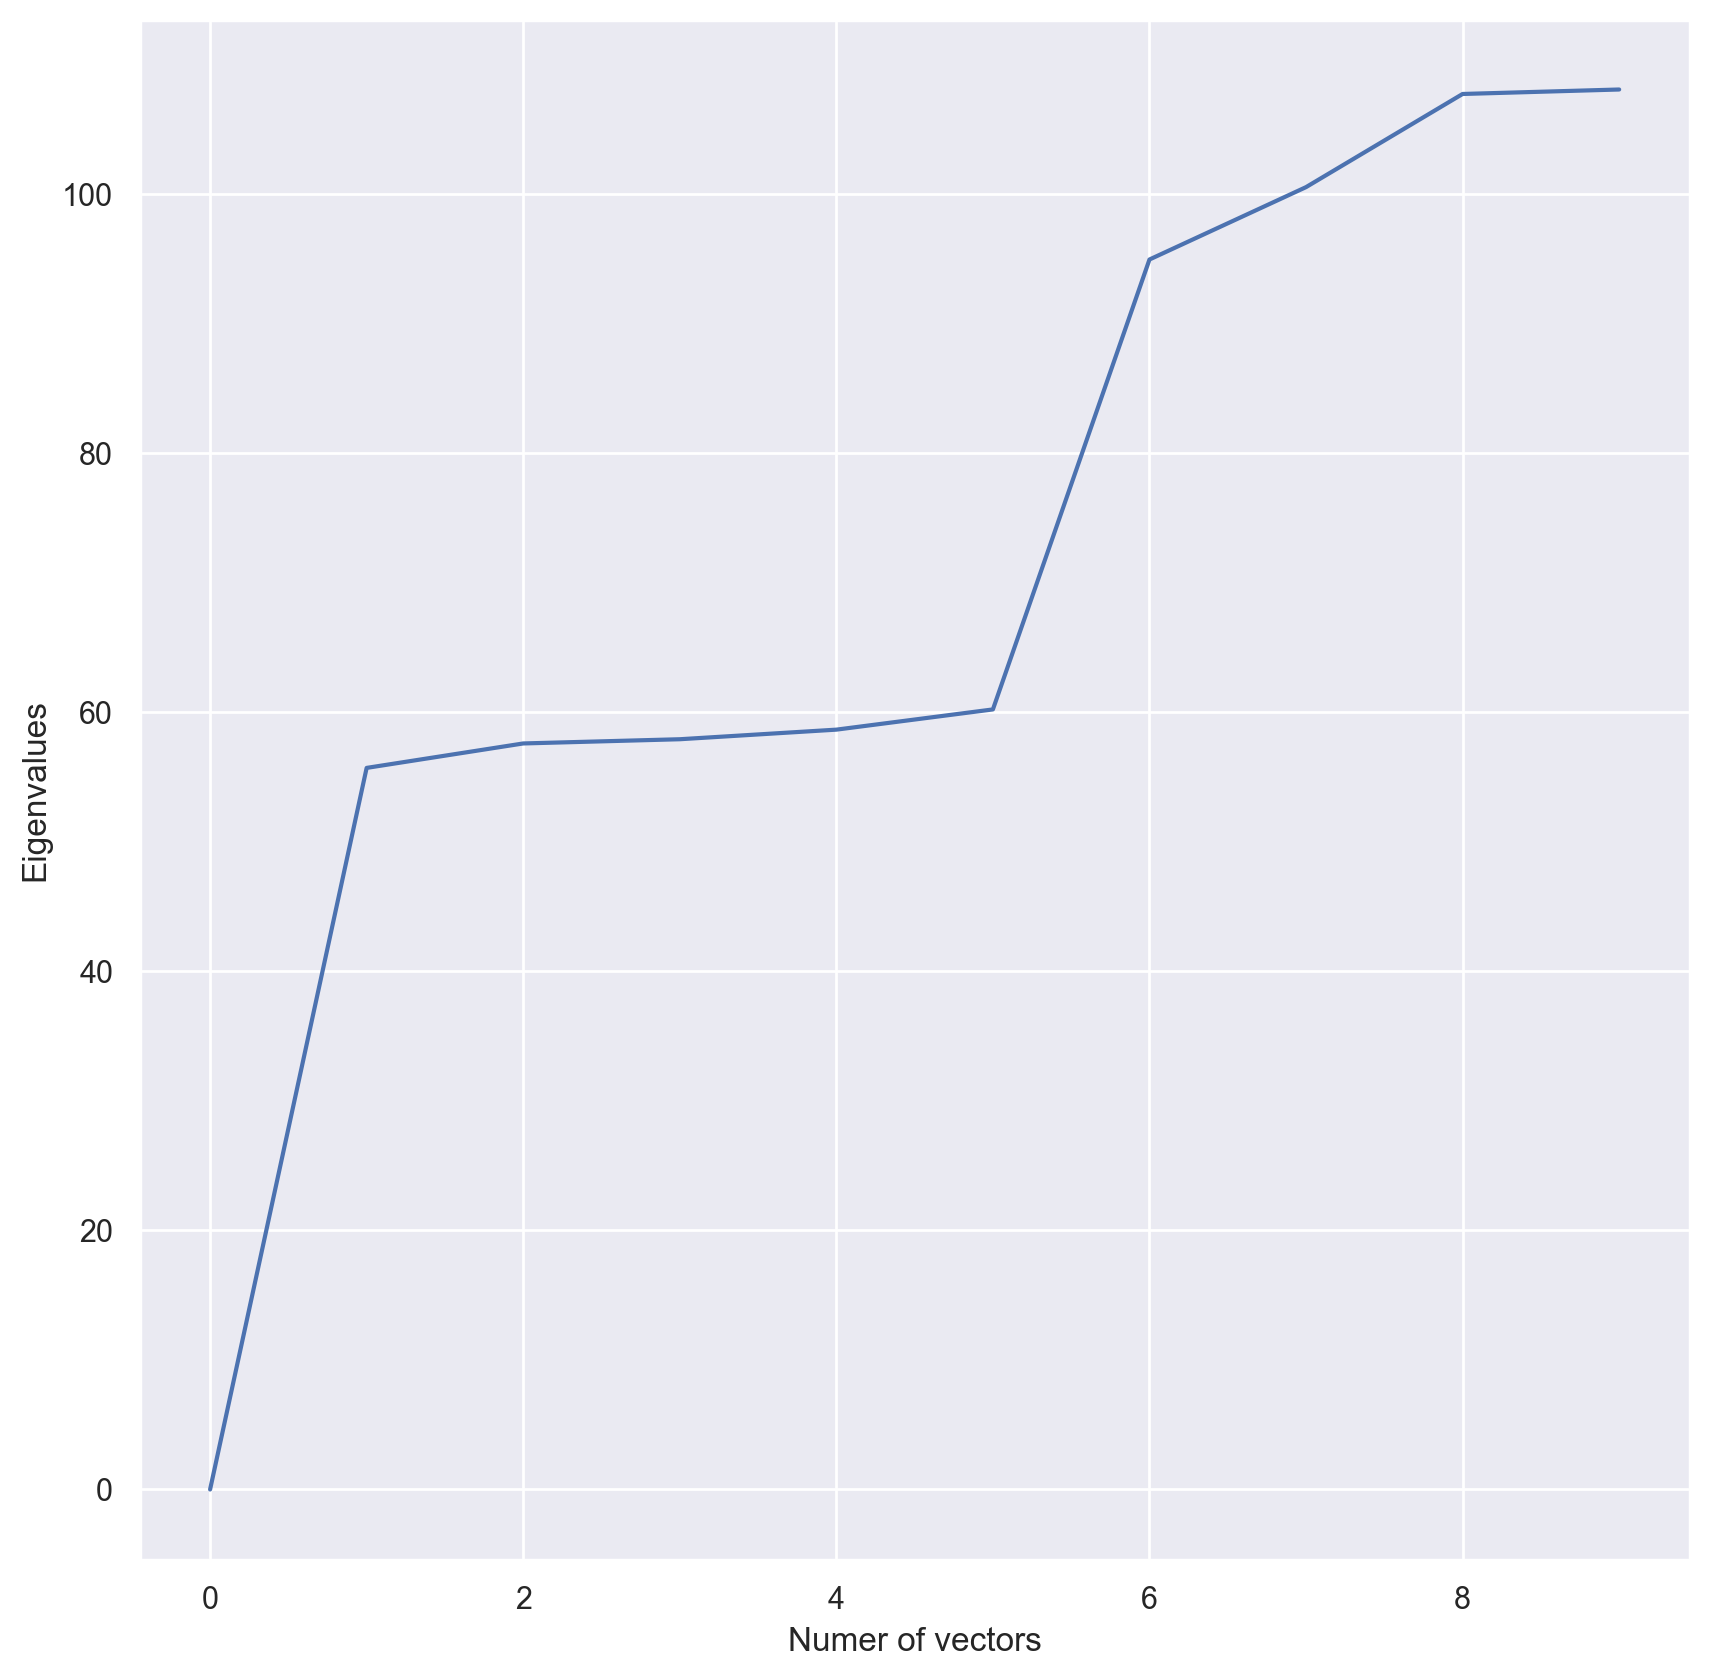

In [29]:
calc_methods_spectral(micro_stem_tfidf, 'tf-idf', 'stem', 'micro')
draw_eigh(micro_stem_tfidf.iloc[:,1:])

100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


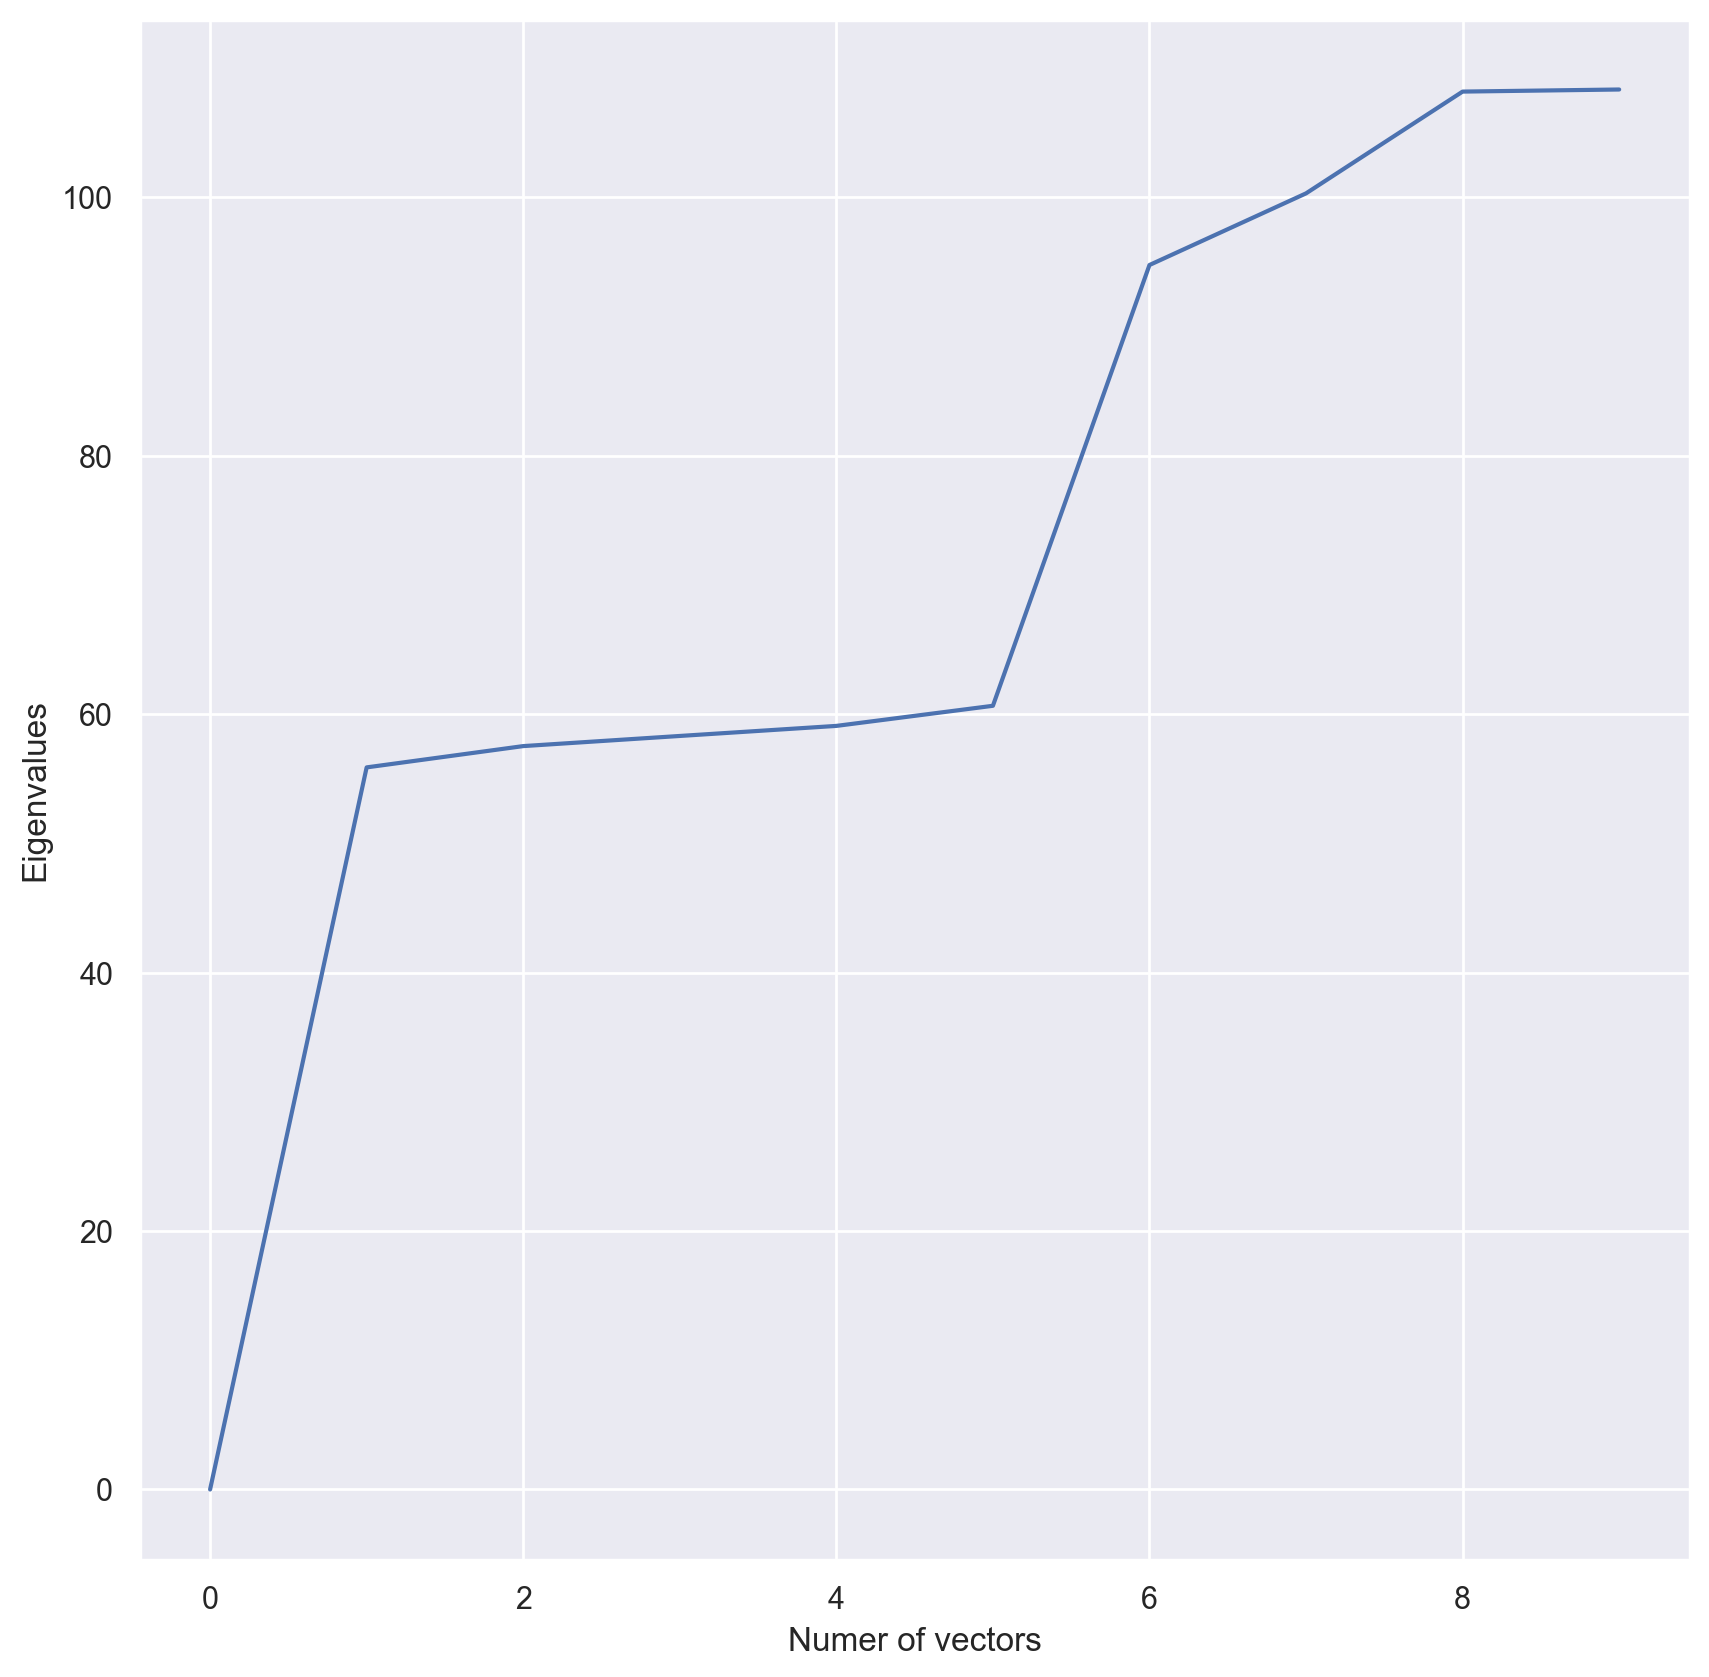

In [30]:
calc_methods_spectral(micro_lem_tfidf, 'tf-idf', 'lem', 'micro')
draw_eigh(micro_lem_tfidf.iloc[:,1:])

#### Fuzzy K-means

In [ ]:
pip install scikit-fuzzy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [31]:
import skfuzzy as fuzz

In [32]:
def calc_methods_fuzzy(embeds, emb_alg, transform, averaging, notes=notes):
    data = embeds.iloc[:,1:].to_numpy()
    banks = list(pd.unique(embeds['bank']))

    for n in tqdm(n_cluster):
        if averaging == 'micro':
          cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n, 2, error=0.005, maxiter=1000, init=None)
          labels = np.argmax(u, axis=0)
          banks_cluster = dict(zip(list(embeds['bank']), [set(list(str(x))) for x in labels]))

        if averaging == 'macro':
          cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, n, 2, error=0.005, maxiter=1000, init=None)
          labels = np.argmax(u, axis=0)

          paper_cluster = pd.DataFrame({'bank':list(embeds['bank'])})
          paper_cluster['labels'] = labels

          banks_cluster = {}
          for i in banks:
              banks_cluster[i] = set(list(str(paper_cluster[paper_cluster['bank'] == i]['labels'].mode().iloc[0])))

        db, ch, ss, bc = calc_metrics(embeds, labels, split_scores(n), banks_cluster)
        notes.loc[len(notes)+1] = [emb_alg, 'fuzzy', transform, n, averaging, db, ch, ss, bc]

In [33]:
calc_methods_fuzzy(micro_lem_tfidf, 'tf-idf','lem', 'micro')

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


In [34]:
calc_methods_fuzzy(micro_stem_tfidf, 'tf-idf','stem', 'micro')

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:05<00:00,  1.09s/it]


### Получение embeddings, обучаемые методы

In [8]:
#препроцессинг для берта
extended_punctuation = punctuation+'«'+'»'+'“'+'”'
digits = '0123456789'
web_tokens = ['quot', 'gt', 'lt', 'br', 'p', 'li', '&lt;/p&gt;']

def bert_processing(text, russian_stopwords=russian_stopwords, punctuation=extended_punctuation, digits=digits, web_tokens=web_tokens):

    text = str(text).lower()

    for i in web_tokens:
      text = text.replace(i, '')

    for i in punctuation:
      text = text.replace(i, '')

    for i in digits:
      text = text.replace(i, '')

    return text

In [9]:
comments_raw_data = pd.read_excel('комментарии_банки.xlsx')
comments_raw_data['datePublished'] = pd.to_datetime(comments_raw_data['datePublished'])
comments_raw_data = comments_raw_data.drop(columns=['Unnamed: 0'])

comments_raw_data['preprocess_text'] = comments_raw_data['description'].parallel_apply(lambda x: bert_processing(x))

In [15]:
bert_df = comments_raw_data[['bank', 'preprocess_text']]
bert_df['bank'] = bert_df['bank'].map(mapper)
bert_df.to_excel('bert_news.xlsx')

In [14]:
bert_df

bank                                    preprocess_text
0       Фольксваген Банк  брал автокредит в этом году сам банк был райф ...
1       Фольксваген Банк  возникла проблема по кредитному договору трети...
2       Фольксваген Банк  сказать что возмущен  не сказать ничего виртуа...
3       Фольксваген Банк   оформил кредит номер договора  внес на счет  ...
4       Фольксваген Банк  г с ооо фольксваген банк рус заключен кредитны...
...                  ...                                                ...
234654        Альфа-Банк   января  года решил заказать себе альфа карту ...
234655        Альфа-Банк  добрый деньв  году мы с супругом взяли ипотечн...
234656        Альфа-Банк  спустя  месяца  пользования кредитной картой  ...
234657        Альфа-Банк  здравствуйте оставила заявку на сайте альфабан...
234658        Альфа-Банк   апреля  по номеру счёта вносил денежные средс...

[234659 rows x 2 columns]

In [26]:
bert_df = pd.read_excel('bert_news.xlsx').drop(columns=['Unnamed: 0']).dropna()

In [27]:
bert_df

bank                                    preprocess_text
0       Фольксваген Банк  брал автокредит в этом году сам банк был райф ...
1       Фольксваген Банк  возникла проблема по кредитному договору трети...
2       Фольксваген Банк  сказать что возмущен  не сказать ничего виртуа...
3       Фольксваген Банк   оформил кредит номер договора  внес на счет  ...
4       Фольксваген Банк  г с ооо фольксваген банк рус заключен кредитны...
...                  ...                                                ...
234654        Альфа-Банк   января  года решил заказать себе альфа карту ...
234655        Альфа-Банк  добрый деньв  году мы с супругом взяли ипотечн...
234656        Альфа-Банк  спустя  месяца  пользования кредитной картой  ...
234657        Альфа-Банк  здравствуйте оставила заявку на сайте альфабан...
234658        Альфа-Банк   апреля  по номеру счёта вносил денежные средс...

[234659 rows x 2 columns]

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny")
model.cuda()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(29564, 312, padding_idx=0)
    (position_embeddings): Embedding(512, 312)
    (token_type_embeddings): Embedding(2, 312)
    (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-2): 3 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=312, out_features=312, bias=True)
            (key): Linear(in_features=312, out_features=312, bias=True)
            (value): Linear(in_features=312, out_features=312, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=312, out_features=312, bias=True)
            (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

In [17]:
def embed_bert_cls(text, model=model, tokenizer=tokenizer):
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

In [ ]:
# получаем эмбединги для каждого банка, как средние
bank_vectors = pd.DataFrame(columns=['bank']+[x for x in range(312)])
for bank in tqdm(np.unique(bert_df['bank'])):
    bank_embeds = pd.DataFrame(columns=[x for x in range(312)])
    bank_text_data = bert_df[bert_df['bank'] == bank]['paper_text']
    for text in bank_text_data:
        bank_embeds = pd.concat([bank_embeds, pd.DataFrame(embed_bert_cls(text).reshape(1,-1))], axis=0)
    sen = np.mean(bank_embeds.to_numpy(), axis=0)
    vec = pd.DataFrame(sen.reshape(1,-1))
    vec.insert(0, "bank", [bank])
    bank_vectors = pd.concat([bank_vectors, vec], axis=0)

bert_micro = bank_vectors.copy()

100%|██████████| 115/115 [00:40<00:00,  2.83it/s]


In [ ]:
bert_micro.to_excel('bert_micro.xlsx', index=False)

In [107]:
bert_micro = pd.read_excel('bert_micro.xlsx')

In [36]:
bert_micro

bank         0         1         2         3         4  \
0            АТБ Банк  0.045410  0.000646 -0.021507  0.006692 -0.015805   
1        Абсолют Банк  0.047429 -0.005657 -0.018402  0.010410 -0.019887   
2            Авангард  0.030985 -0.012751 -0.025294  0.010945 -0.022998   
3    Авто Финанс Банк  0.026298 -0.007188 -0.032909  0.008565 -0.018231   
4        Автоградбанк  0.030226 -0.005841 -0.028305  0.010496 -0.016544   
..                ...       ...       ...       ...       ...       ...   
161     кубань кредит  0.035628 -0.005530 -0.027427  0.015063 -0.022613   
162            ндбанк  0.024850 -0.012259 -0.028629  0.020325 -0.025011   
163          приморье  0.043063 -0.001832 -0.024539  0.013151 -0.014494   
164              рнкб  0.030837 -0.004679 -0.025502  0.010885 -0.020514   
165        энергобанк  0.028763 -0.014174 -0.026852  0.008081 -0.018315   

            5         6         7         8  ...       302       303  \
0    0.000648 -0.025415 -0.081937  0.035584  ...  0.011614 -0.062119   
1   -0.002109 -0.026148 -0.089504  0.045356  ...  0.012854 -0.057695   
2   -0.011351 -0.021049 -0.090102  0.054516  ...  0.019369 -0.085674   
3   -0.012872 -0.026270 -0.094577  0.053606  ...  0.022079 -0.064941   
4   -0.012942 -0.032060 -0.085038  0.037285  ...  0.006777 -0.065302   
..        ...       ...       ...       ...  ...       ...       ...   
161 -0.011932 -0.031968 -0.096606  0.049087  ...  0.016396 -0.078564   
162  0.001448 -0.016844 -0.097353  0.062535  ...  0.011426 -0.088116   
163 -0.012364 -0.028124 -0.086534  0.043216  ...  0.016398 -0.076709   
164 -0.008466 -0.024414 -0.088503  0.052674  ...  0.017258 -0.077818   
165 -0.015749 -0.026161 -0.088032  0.054497  ...  0.014925 -0.085887   

          304       305       306       307       308       309       310  \
0    0.003708  0.066314 -0.001179  0.005403  0.040981 -0.048830 -0.001022   
1    0.001237  0.061333 -0.000393 -0.004466  0.036366 -0.045983 -0.002497   
2   -0.011232  0.064733 -0.004021 -0.002370  0.042476 -0.055672 -0.013859   
3    0.002026  0.066316  0.001346 -0.009850  0.038864 -0.059692 -0.004522   
4   -0.016277  0.064367 -0.000360  0.002288  0.030388 -0.040203 -0.003340   
..        ...       ...       ...       ...       ...       ...       ...   
161 -0.010544  0.070351 -0.010691  0.004647  0.047714 -0.049060 -0.011705   
162 -0.009474  0.078780 -0.017056  0.004551  0.047352 -0.060751 -0.029049   
163 -0.017426  0.067276 -0.007632  0.002906  0.042044 -0.050472 -0.015767   
164 -0.007005  0.068381 -0.003845 -0.000045  0.040421 -0.048730 -0.008998   
165 -0.010641  0.067177 -0.003394  0.001318  0.039950 -0.059236 -0.022780   

          311  
0   -0.056864  
1   -0.052568  
2   -0.049142  
3   -0.050234  
4   -0.052005  
..        ...  
161 -0.050195  
162 -0.040750  
163 -0.057550  
164 -0.052173  
165 -0.047779  

[166 rows x 313 columns]

#### K-means

100%|██████████| 9/9 [00:00<00:00, 44.80it/s]


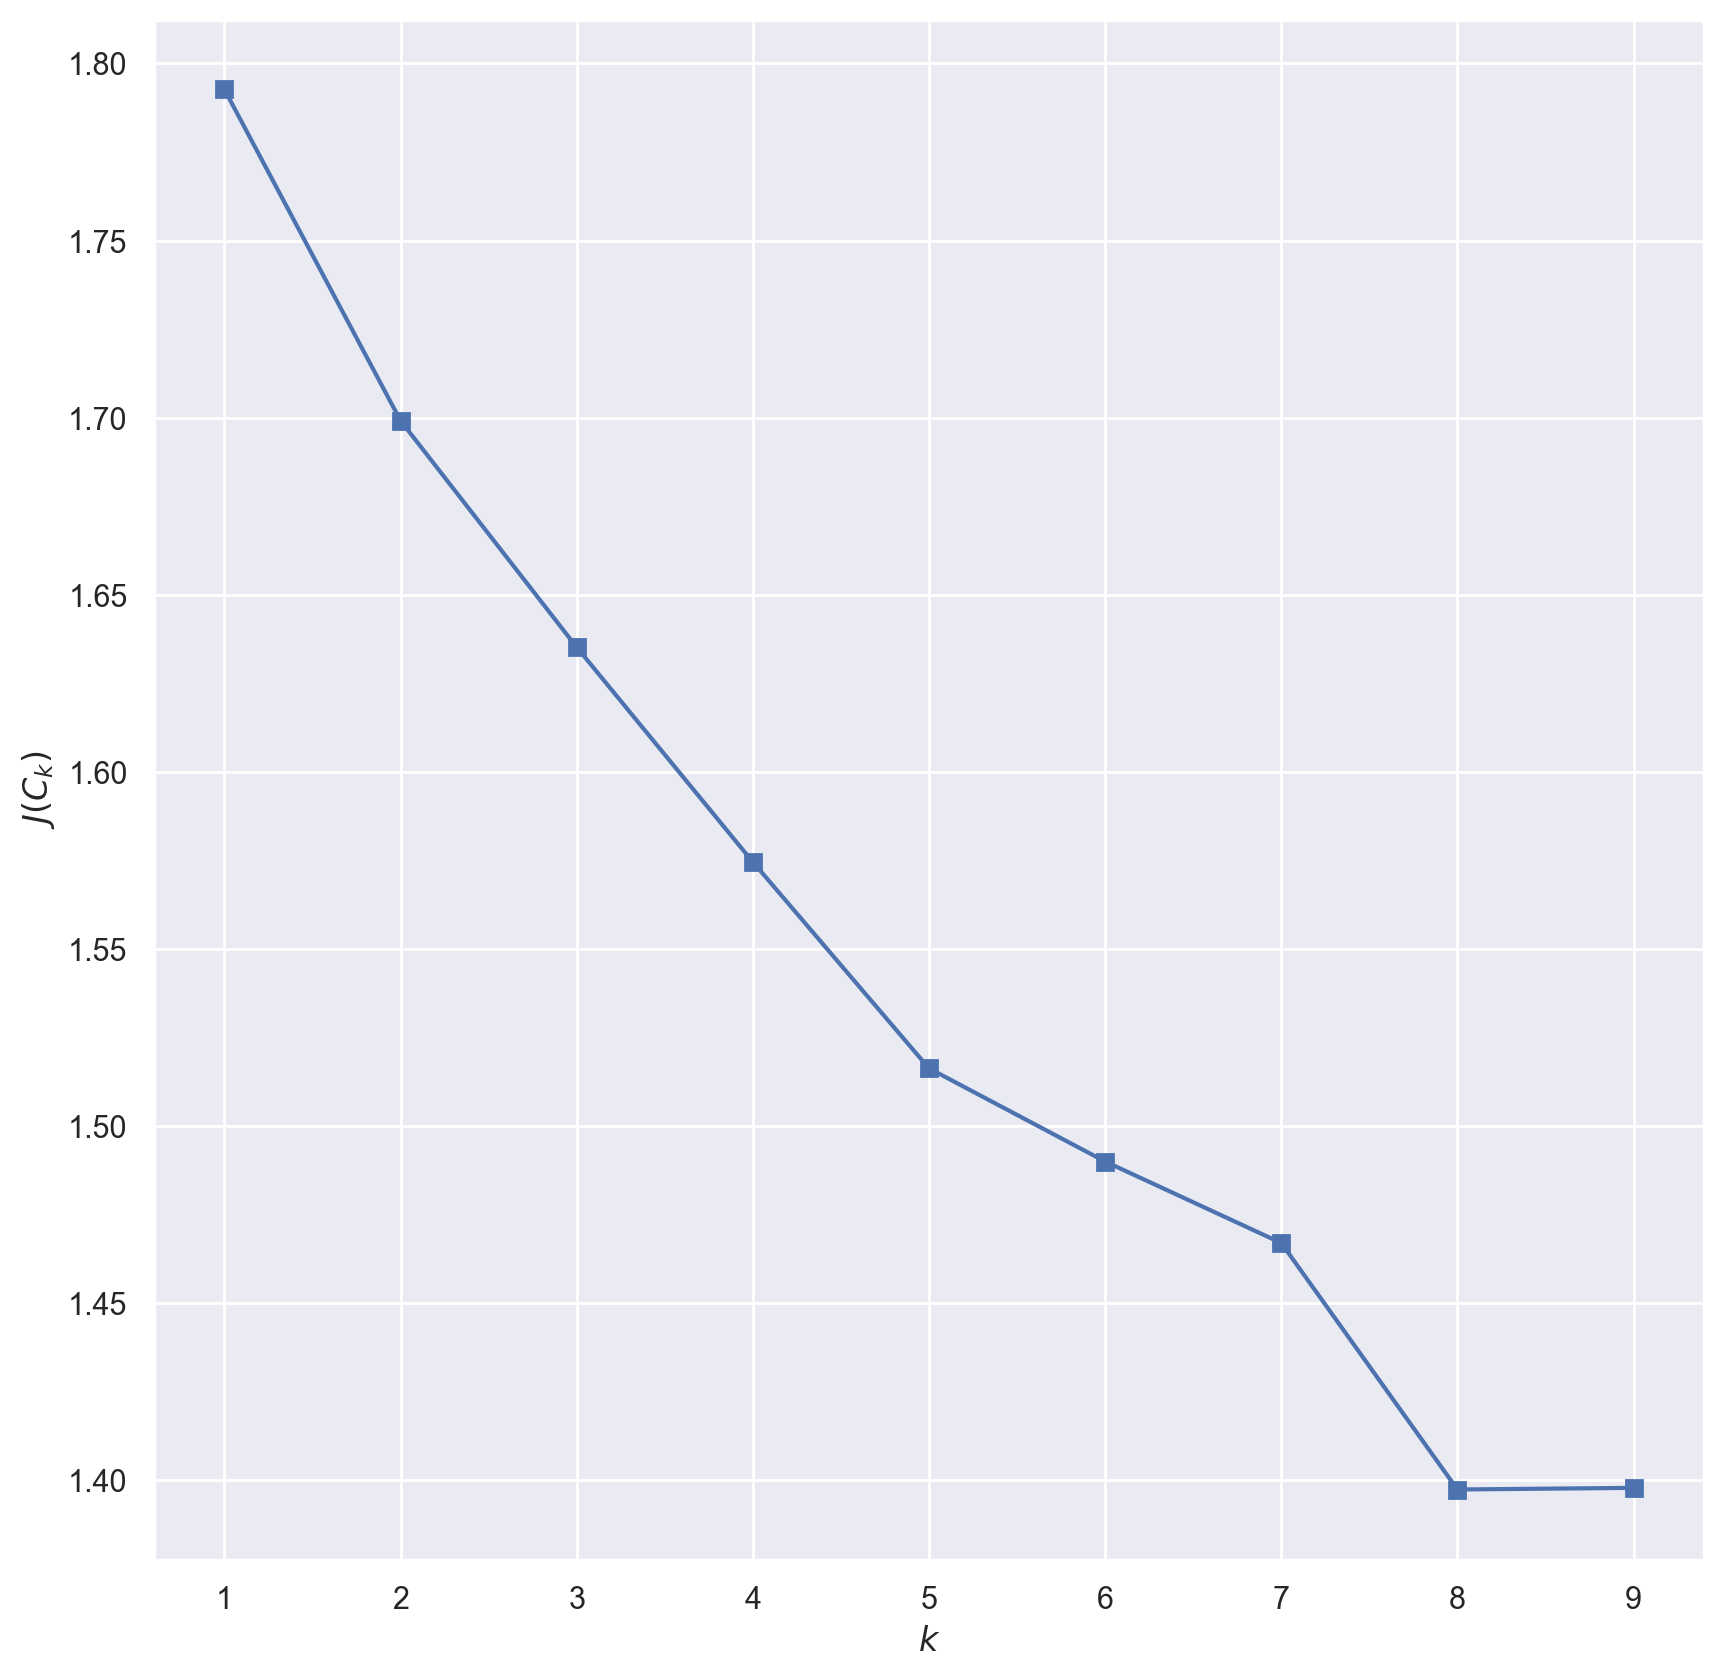

In [37]:
calc_methods_kmeans(bert_micro, 'bert', None, 'micro')
plot_inertia(bert_micro)

#### DBSCAN

100%|██████████| 20/20 [00:00<00:00, 71.97it/s]


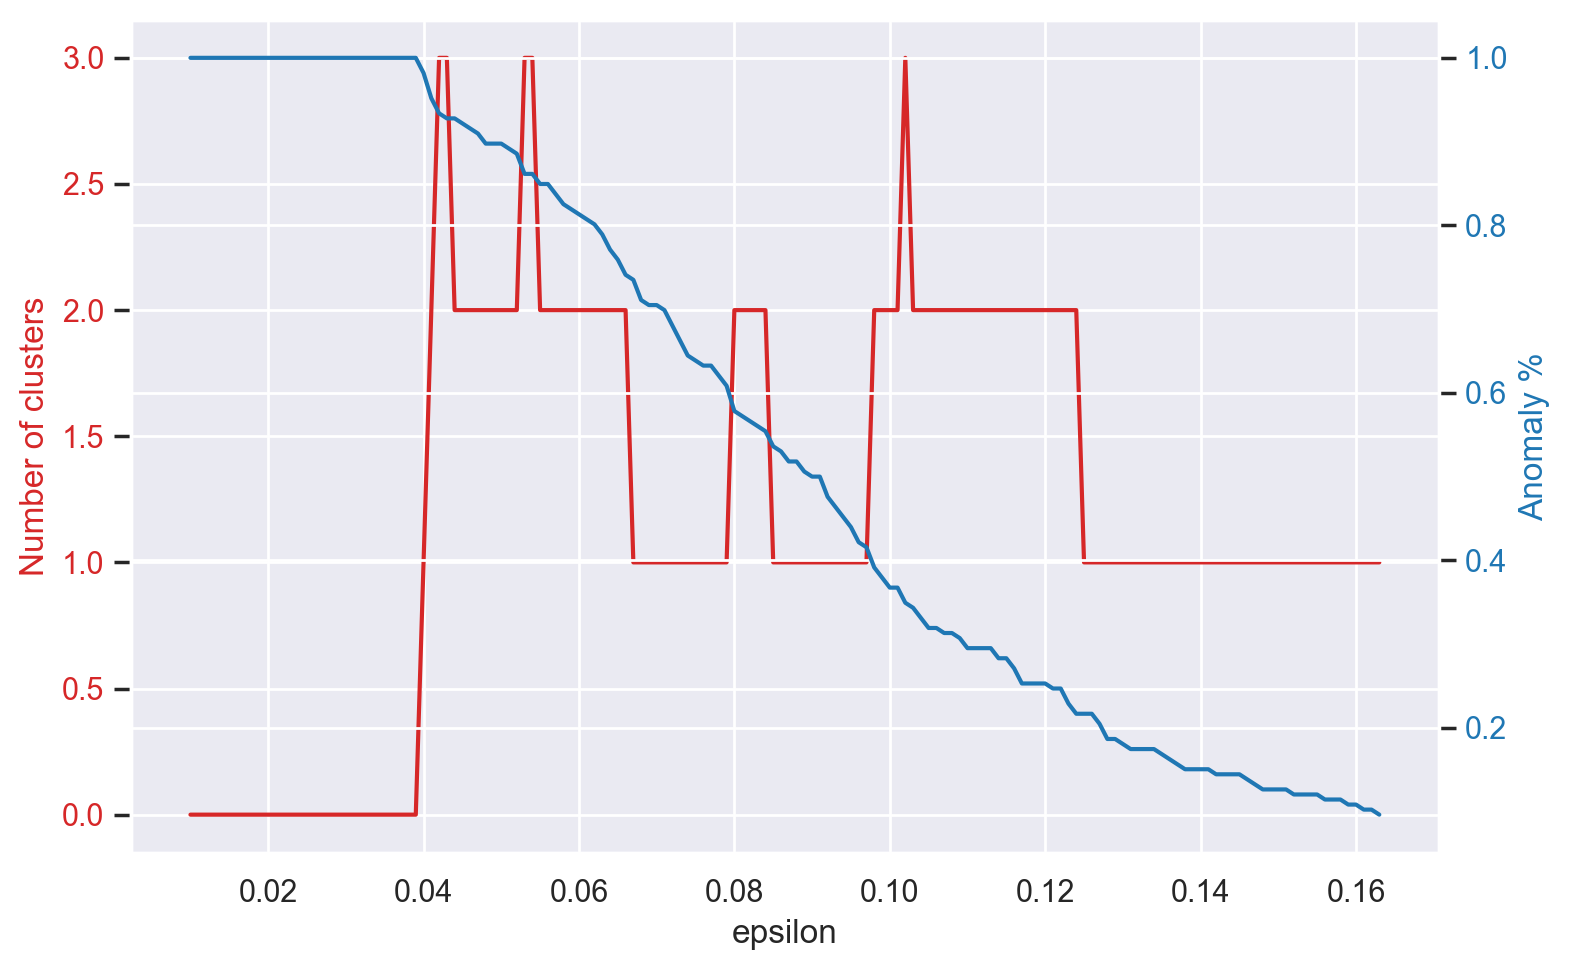

In [38]:
eps_list = [0.04 + 0.01 * x for x in range(20)]
calc_methods_dbscan(bert_micro, 'bert', None, 'micro', eps_list=eps_list)
draw_anomaly_plot(bert_micro.iloc[:,1:], eps=0.01, eps_grow=0.001)

#### Spectral

100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


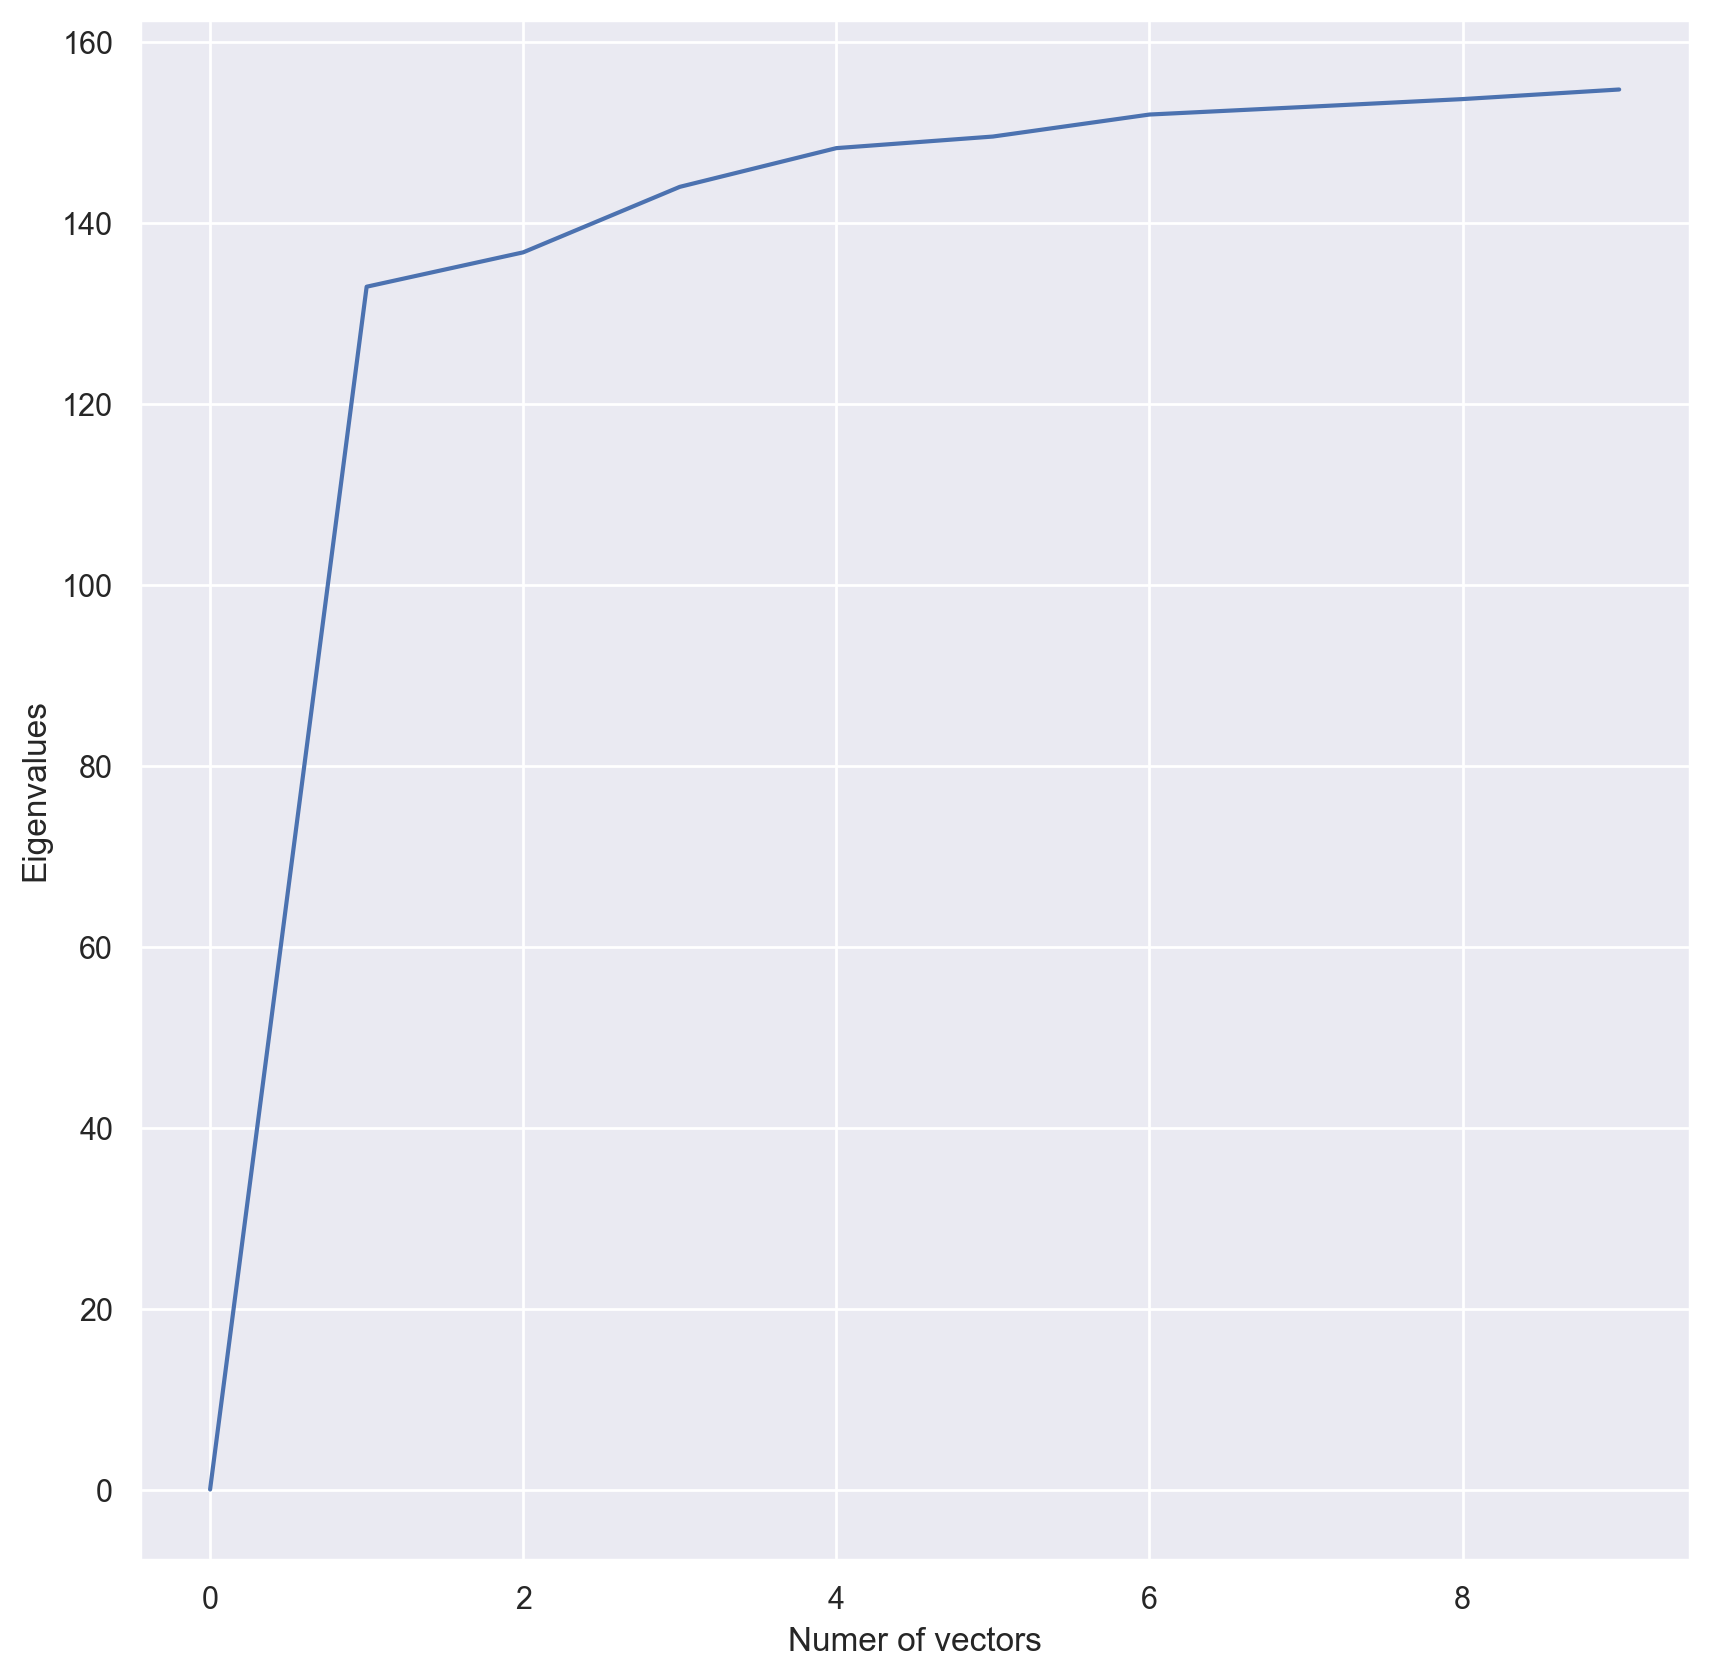

In [39]:
calc_methods_spectral(bert_micro, 'bert', None, 'micro')
draw_eigh(bert_micro.iloc[:,1:])

#### Fuzzy K-means

In [40]:
calc_methods_fuzzy(bert_micro, 'bert', None, 'micro')

100%|██████████| 5/5 [00:00<00:00, 15.89it/s]


### Сравнение метрик

In [43]:
notes.sort_values('f1_bcubed').to_excel('nps_result.xlsx')

### Анализ лучших класстеризаций

In [125]:
comments_raw_data = pd.read_excel('комментарии_банки.xlsx')
comments_raw_data['datePublished'] = pd.to_datetime(comments_raw_data['datePublished'])
comments_raw_data = comments_raw_data.drop(columns=['Unnamed: 0'])


rating_data = comments_raw_data[['bank', 'rating']]

mapper = pd.read_excel('mapper.xlsx')
mapper = mapper.set_index('bank').T.to_dict('records')[0]

rating_data['bank'] = rating_data['bank'].map(mapper)

rating_data = rating_data.groupby('bank').agg({'rating':'mean'}).reset_index()

/var/folders/0v/mjh6qpnj1jvg0mmzcsb5mz5r0000gn/T/ipykernel_1179/509253612.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_data['bank'] = rating_data['bank'].map(mapper)


#### bert

In [168]:
from sklearn.cluster import SpectralClustering

data_ = bert_micro.iloc[:,1:].to_numpy()
banks = list(bert_micro['bank'])

spectr = SpectralClustering(n_clusters=2, random_state=42)
spectr.fit(data_)

banks_cluster = dict(zip(banks, [set(list(str(x))) for x in spectr.labels_]))

embeds = bert_micro.copy()
embeds.insert(1, 'label', list(spectr.labels_))

In [169]:
clusster_data = pd.DataFrame({'bank':banks})
clusster_data['clusters'] = spectr.labels_

In [170]:
clusster_data = rating_data.merge(clusster_data, on='bank', how='left')

In [171]:
clusster_data.groupby('clusters').agg({'rating':'mean'})

rating
clusters          
0         1.944658
1         3.188758

In [172]:
from sklearn.manifold import TSNE

tsne = TSNE(learning_rate='auto', init='random')
d2_feat = tsne.fit_transform(bert_micro.iloc[:,2:])

clusster_data['TSNE_0'] = d2_feat[:,0]
clusster_data['TSNE_1'] = d2_feat[:,1]

In [173]:
clusster_data

bank    rating  clusters    TSNE_0    TSNE_1
0            АТБ Банк  3.320000         1 -5.213638 -2.034201
1        Абсолют Банк  3.328000         1 -5.570022 -1.491468
2            Авангард  1.350000         0  2.819733  0.721201
3    Авто Финанс Банк  2.500000         0  1.952578  4.199101
4        Автоградбанк  2.625000         0 -2.932538  1.742037
..                ...       ...       ...       ...       ...
161     кубань кредит  1.720000         0  2.020717 -0.937643
162            ндбанк  1.000000         0  5.510706  2.738614
163          приморье  1.761905         0 -0.520907  2.628552
164              рнкб  2.023333         0  0.548290 -0.139215
165        энергобанк  2.285714         0  3.092412 -0.276311

[166 rows x 5 columns]

(array([34., 31., 26., 21., 18., 10., 12.,  4.,  6.,  4.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

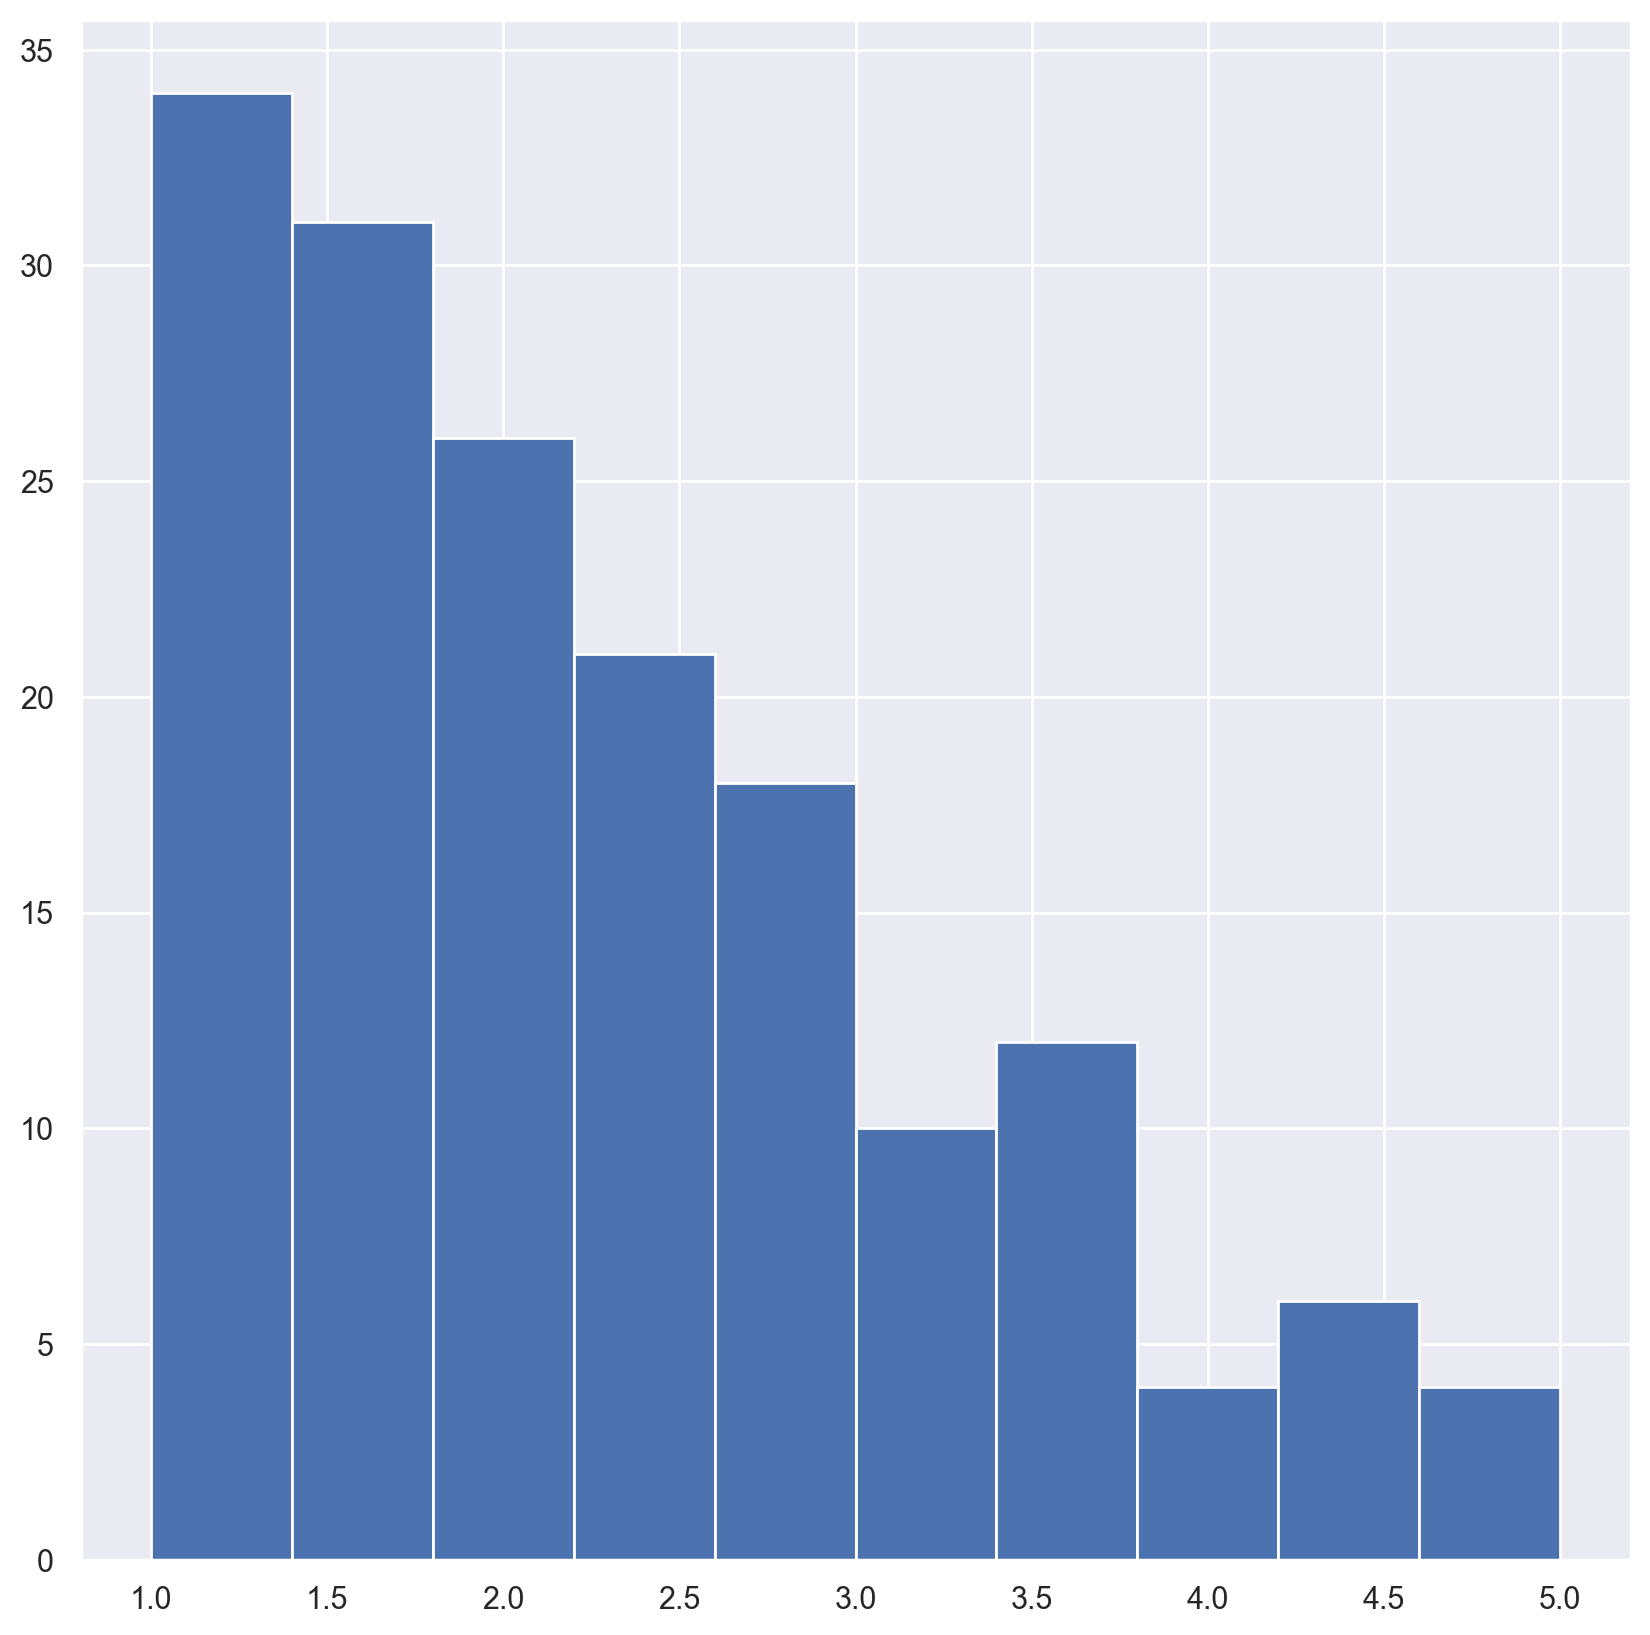

In [196]:
sns.set(rc={'figure.figsize':(10, 10)})
plt.hist(clusster_data['rating'])

<Axes: xlabel='rating', ylabel='bank'>

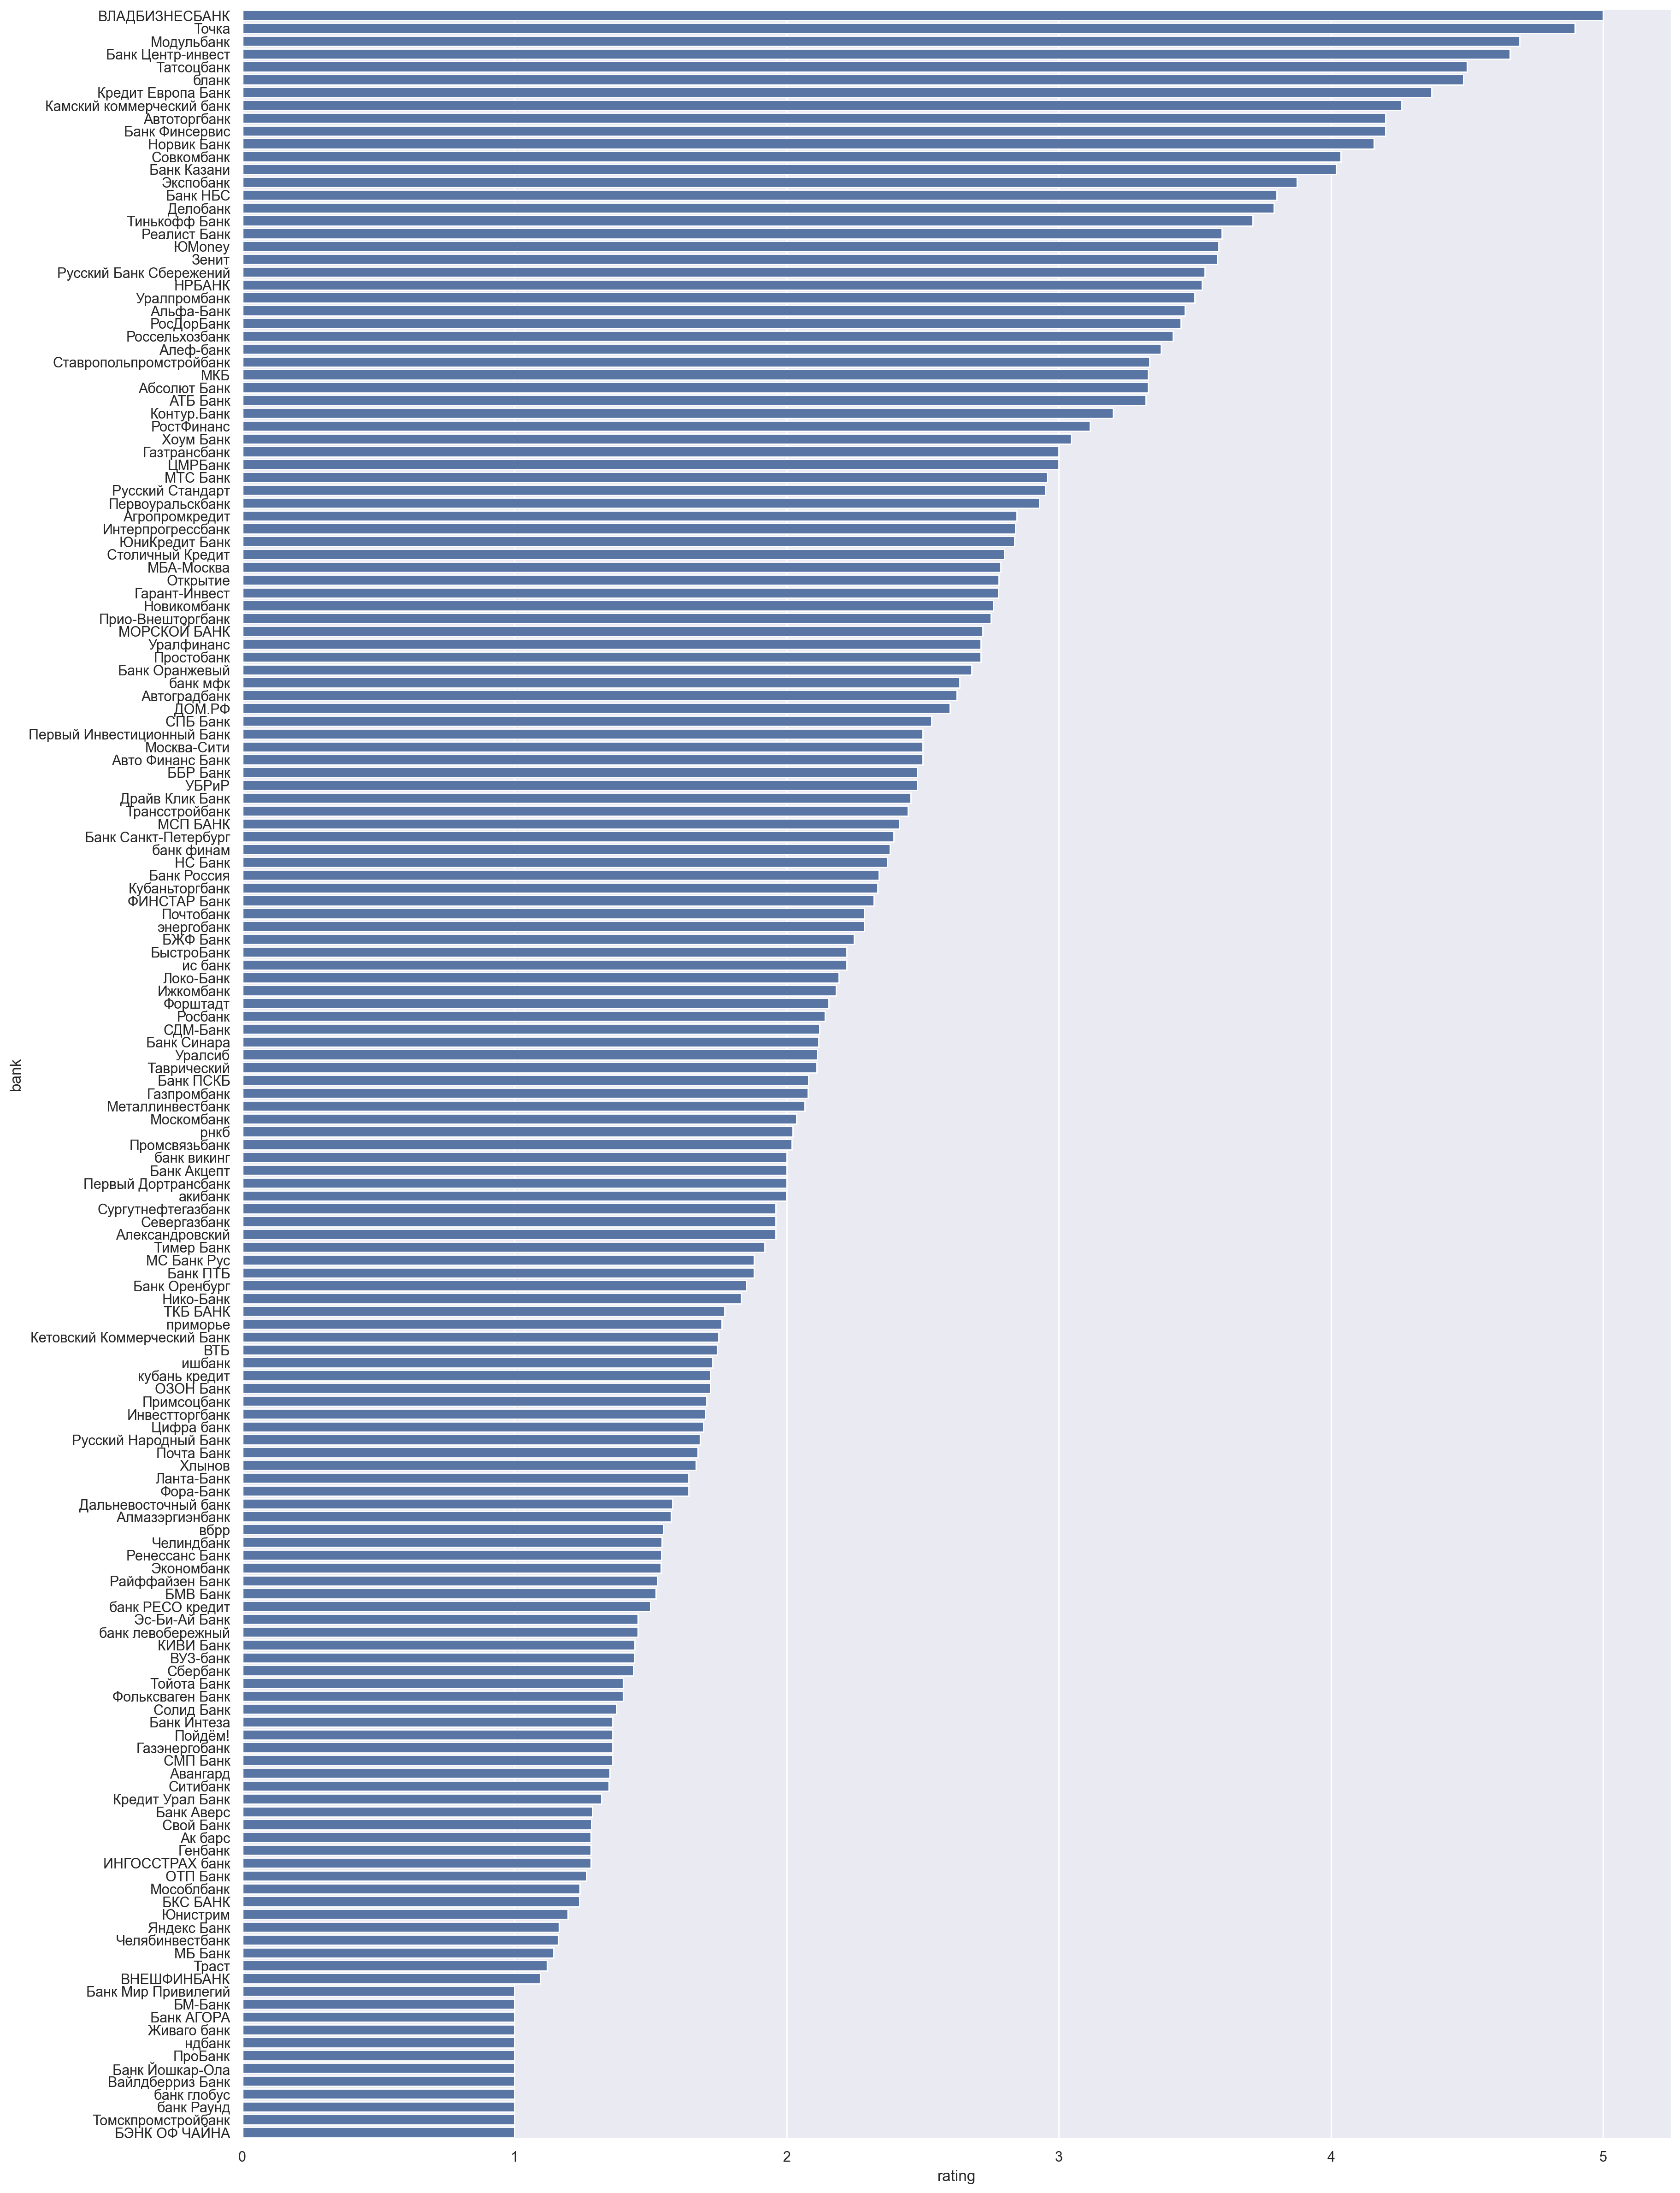

In [194]:
sns.set(rc={'figure.figsize':(20, 30)})
sns.barplot(data=clusster_data, y='bank',x='rating', order=clusster_data.sort_values(by='rating', ascending=False)['bank'])

(array([121.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  45.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

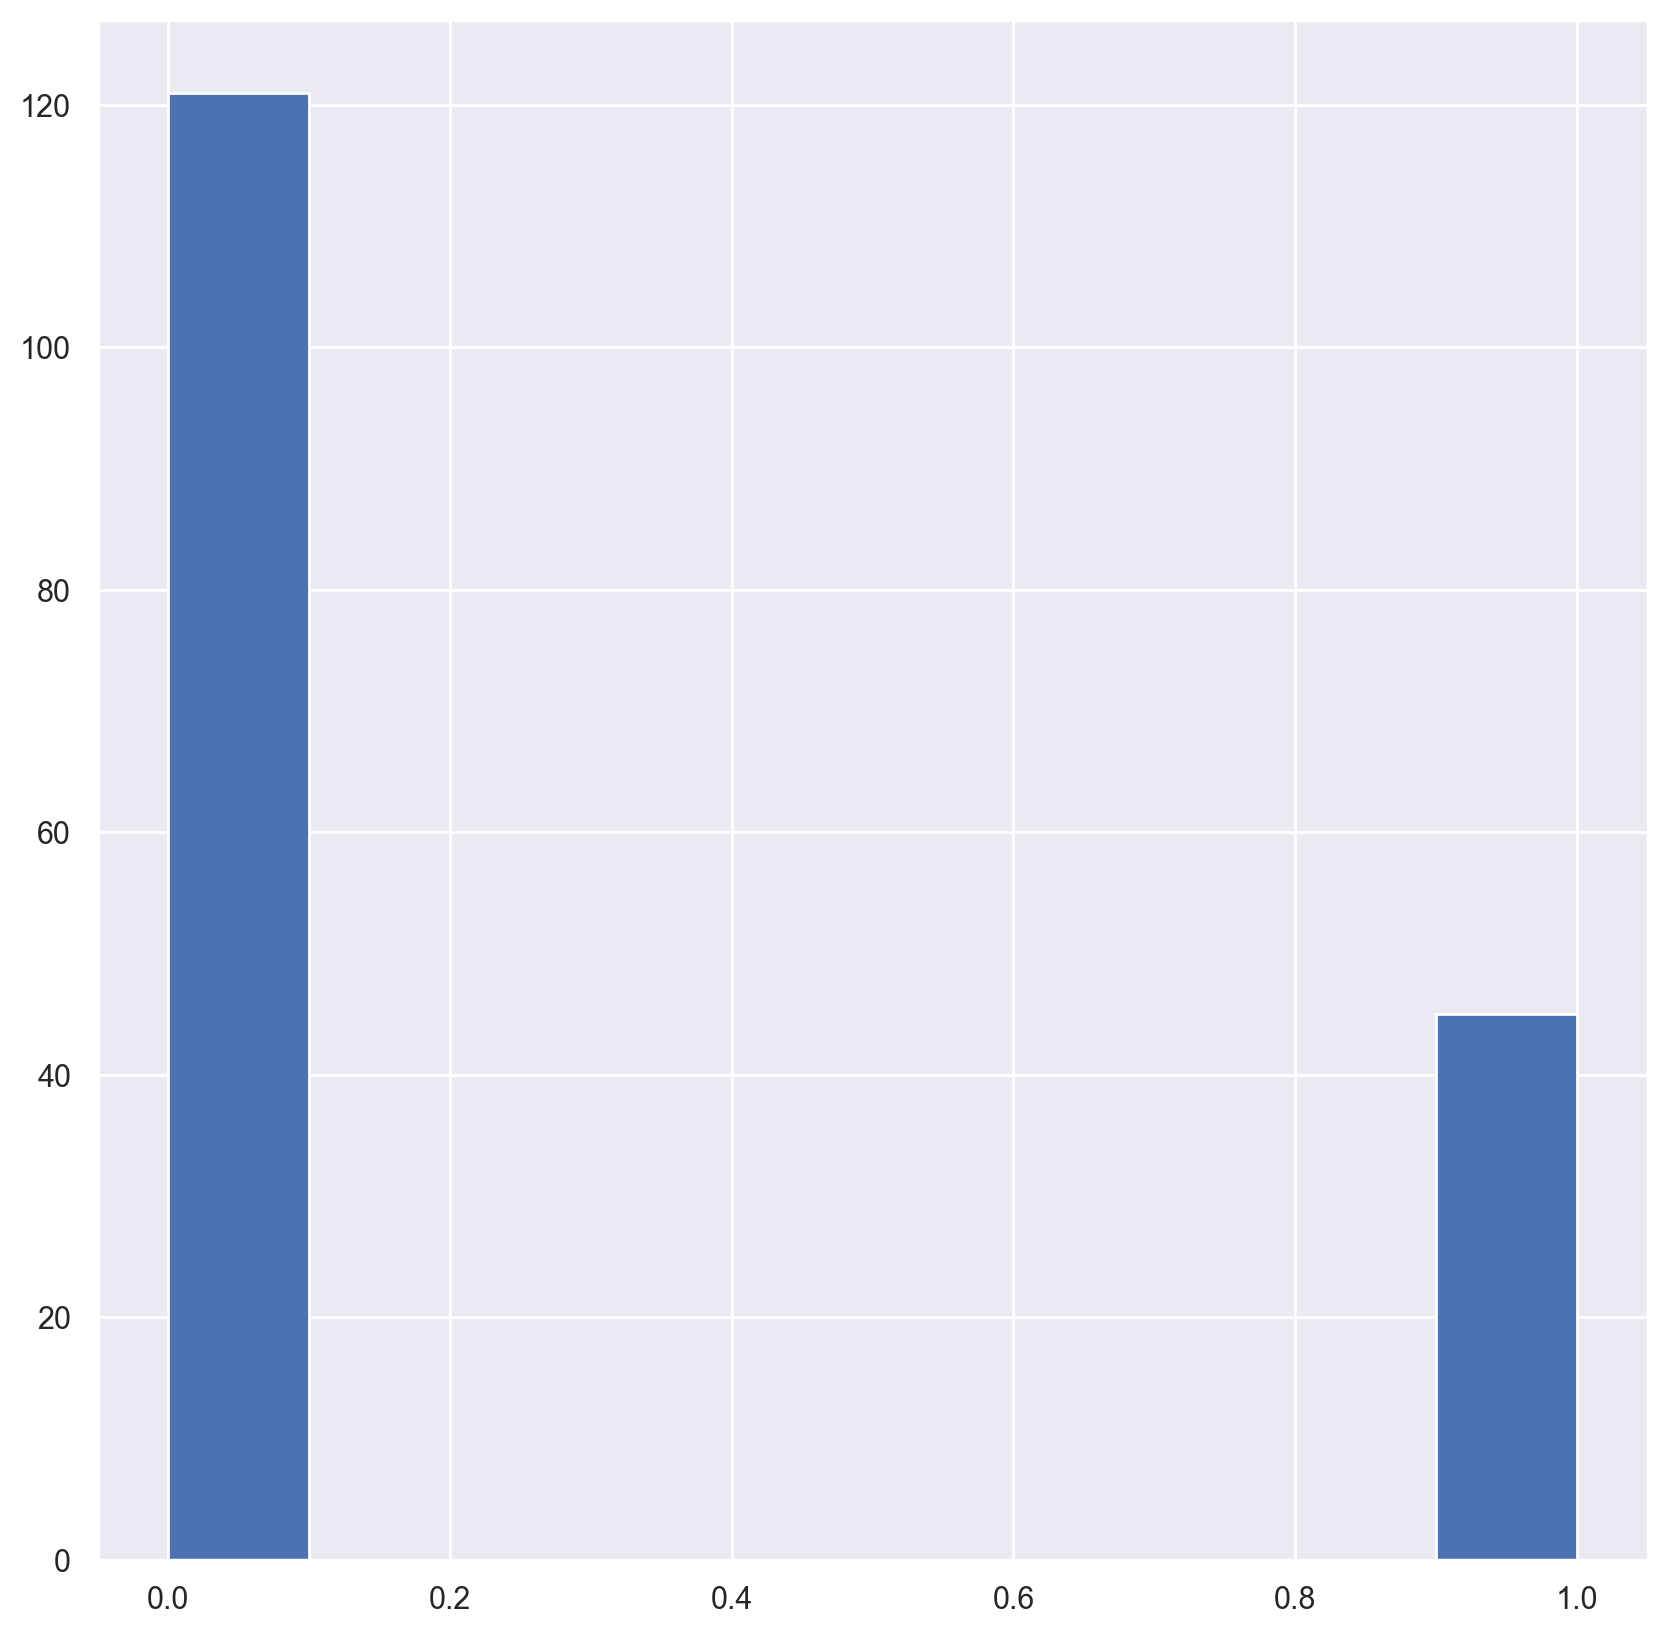

In [174]:
plt.hist(clusster_data['clusters'])

In [163]:
a = data[['bank', 'paper_stemming_text']].merge(clusster_data[['bank',	'clusters']], on='bank', how='left')

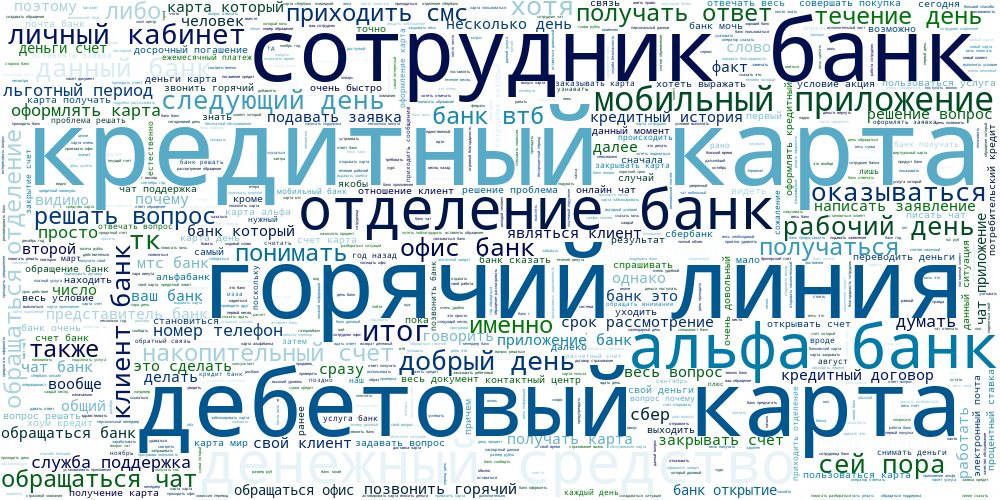

In [164]:
draw_cloud(a[a['clusters'] == 0]['paper_stemming_text'])

In [165]:
list(clusster_data[clusster_data['clusters'] == 0]['bank'])

['Авангард',
 'Авто Финанс Банк',
 'Автоградбанк',
 'Автоторгбанк',
 'Агропромкредит',
 'Ак барс',
 'Александровский',
 'Алеф-банк',
 'Алмазэргиэнбанк',
 'Альфа-Банк',
 'БЖФ Банк',
 'БКС БАНК',
 'БМ-Банк',
 'БМВ Банк',
 'Банк Аверс',
 'Банк Акцепт',
 'Банк Интеза',
 'Банк Йошкар-Ола',
 'Банк Казани',
 'Банк Оранжевый',
 'Банк Оренбург',
 'Банк ПСКБ',
 'Банк ПТБ',
 'Банк Санкт-Петербург',
 'Банк Синара',
 'Банк Финсервис',
 'ВНЕШФИНБАНК',
 'ВТБ',
 'ВУЗ-банк',
 'Вайлдберриз Банк',
 'Газпромбанк',
 'Газэнергобанк',
 'Гарант-Инвест',
 'Генбанк',
 'Дальневосточный банк',
 'Драйв Клик Банк',
 'Живаго банк',
 'ИНГОССТРАХ банк',
 'Ижкомбанк',
 'Инвестторгбанк',
 'КИВИ Банк',
 'Кетовский Коммерческий Банк',
 'Контур.Банк',
 'Кредит Урал Банк',
 'Кубаньторгбанк',
 'Ланта-Банк',
 'Локо-Банк',
 'МБ Банк',
 'МБА-Москва',
 'МС Банк Рус',
 'МТС Банк',
 'Москва-Сити',
 'Москомбанк',
 'Мособлбанк',
 'НРБАНК',
 'Нико-Банк',
 'ОЗОН Банк',
 'ОТП Банк',
 'Открытие',
 'Первый Дортрансбанк',
 'Пойдём!',
 'По

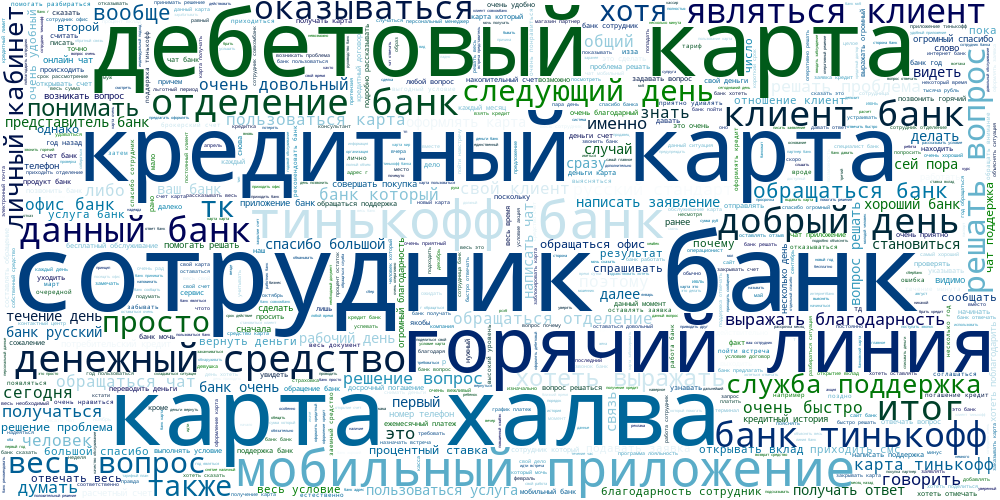

In [166]:
draw_cloud(a[a['clusters'] == 1]['paper_stemming_text'])

In [175]:
list(clusster_data[clusster_data['clusters'] == 1]['bank'])

['АТБ Банк',
 'Абсолют Банк',
 'ББР Банк',
 'БЭНК ОФ ЧАЙНА',
 'Банк АГОРА',
 'Банк Мир Привилегий',
 'Банк НБС',
 'Банк Россия',
 'Банк Центр-инвест',
 'БыстроБанк',
 'ВЛАДБИЗНЕСБАНК',
 'Газтрансбанк',
 'ДОМ.РФ',
 'Делобанк',
 'Зенит',
 'Интерпрогрессбанк',
 'Камский коммерческий банк',
 'Кредит Европа Банк',
 'МКБ',
 'МОРСКОЙ БАНК',
 'МСП БАНК',
 'Металлинвестбанк',
 'Модульбанк',
 'НС Банк',
 'Новикомбанк',
 'Норвик Банк',
 'Первоуральскбанк',
 'Первый Инвестиционный Банк',
 'Прио-Внешторгбанк',
 'Реалист Банк',
 'РосДорБанк',
 'Россельхозбанк',
 'РостФинанс',
 'Русский Банк Сбережений',
 'Русский Стандарт',
 'Совкомбанк',
 'Столичный Кредит',
 'Татсоцбанк',
 'Тинькофф Банк',
 'Точка',
 'Уралпромбанк',
 'ЦМРБанк',
 'ЮниКредит Банк',
 'банк финам',
 'бланк']

In [ ]:
clusster_data.to_excel('bert+spectral.xlsx')

Text(0.5, 1.0, 'Spectr')

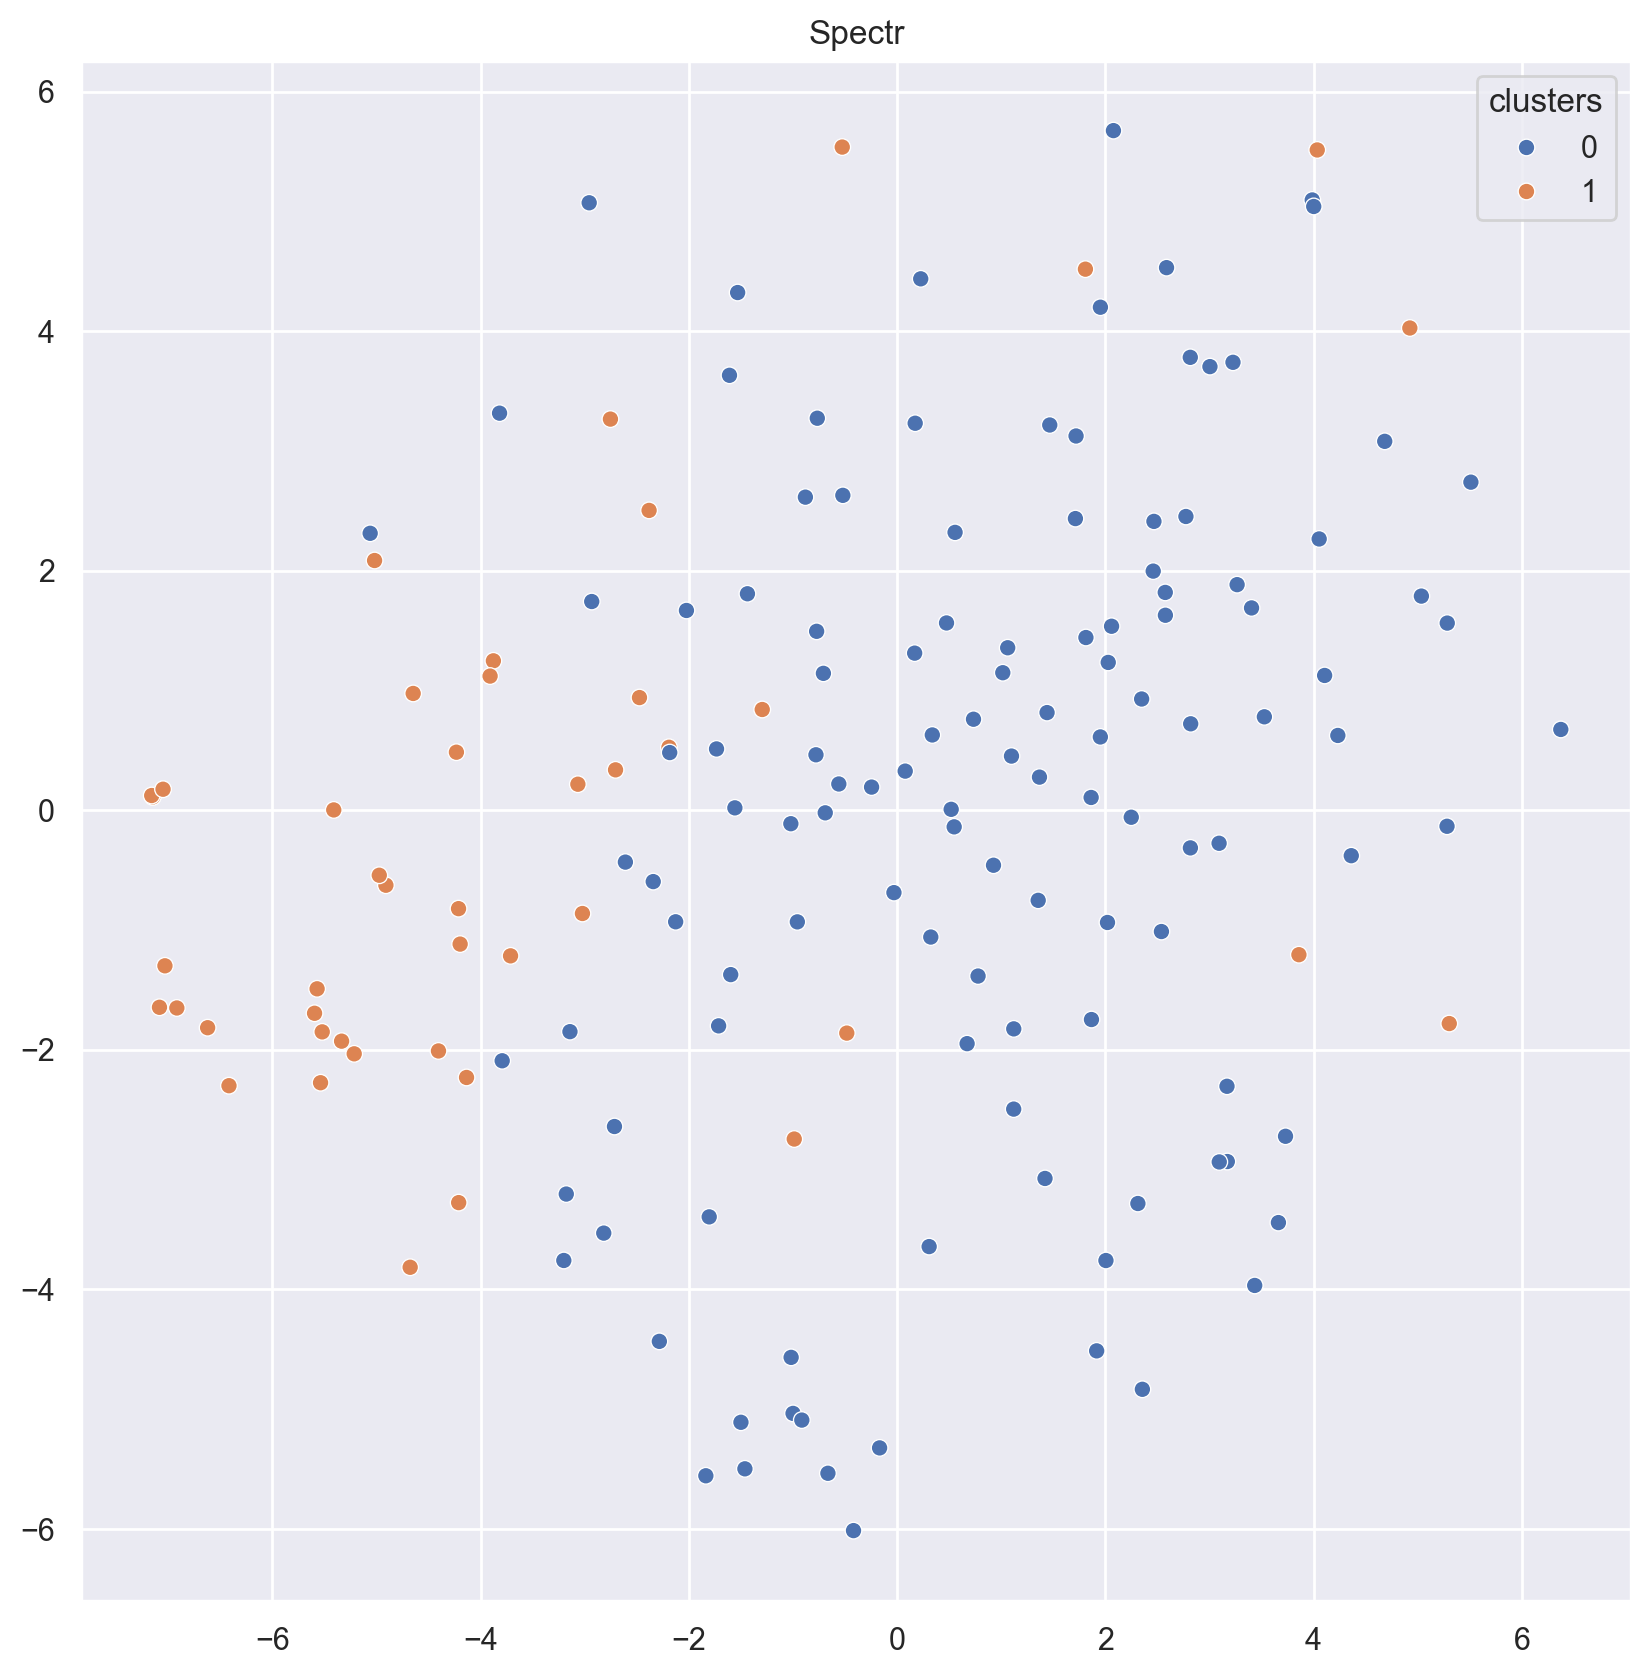

In [203]:
sns.set(rc={'figure.figsize':(10, 10)})
sns.scatterplot(data = clusster_data, x='TSNE_0', y='TSNE_1', hue=clusster_data['clusters']).set(ylabel=None, xlabel=None)
plt.title('Spectr')

___